# Language Models
## Homework 2: Embeddings

**Instructor**: Dr. Pavlos Protopapas<br />
**Maximum Score**: 89


## INSTRUCTIONS

- This homework is a notebook. Download and work on it on your local machine or work on it in Colab.

- This homework should be submitted in a team.

- Ensure you and your partners together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit.

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code.

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**.

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropriate plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

## **Names of the people who worked on this homework**

### Group 1

- Huang Xi
- Qi Weijian
- Wang Shixiao
- Ye Yilin
- Zhong Wentao
- Zhou Juncong

## **Setup Notebook**

**Imports**

In [1]:
import requests
import urllib
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model

In [2]:
# here we import some extra libraries that we will need for this homework
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm
from tensorflow.keras.models import load_model
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

**Verify Setup**

In [3]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.9.0
keras version 2.9.0
Eager Execution Enabled: True
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-04 19:20:31.969252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-04 19:20:31.969398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## **PART 1 [25 points]: Word2Vec from scratch**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

Word2Vec architecture allows us to get *contextual* representations of word tokens.     

There are several methods to build a word embedding. We will focus on the SGNS architecture.

![](https://drive.google.com/uc?export=view&id=1eyozbhsrzRaKc86SM7LblgzVMZKAW8Pe)

In this problem, you are asked to build and analyze a Word2Vec architecture trained on Wikipedia articles.

</div>

### **PART 1: Questions**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

    
**1.1 [5 points] Model Processing**
<br />
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
**1.1.1** - Get the data    

- Get the data from the `text8.zip` file.
    `text8.zip` is a small, *cleaned* subset of a large corpus of data scraped from Wikipedia pages. More details can be found [here](https://paperswithcode.com/sota/language-modelling-on-text8)
    It is usually used to quickly train, or test language models.

- Split the data by whitespace and print the first 10 words to check if has been correctly loaded.

    **NOTE:** For this part of the homework, all words will be in their lowercase for simplicity of analysis
<br />    

**1.1.2** - Build the dataset

- Write a function that takes the `vocabulary_size` and `corpus` as input, and outputs:
    - Tokenized data
    - count of each token
    - A dictionary that maps words to tokens
    - A dictionary that maps tokens to words
    You can use the same function used in **Lab 3**, or else you can use [`tf.keras.Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to write a similar function.
- Print the first 10 tokens and reverse them to words to confirm a match to the initial print above.
     
  
Eg. `corpus[:10] = ['this','is,'an','example',...]`

`data[:10] = [44,26,24,16,...]`
    
`reversed_data =['this','is,'an','example',...]`

**NOTE**: Choose a sufficiently large vocabulary size. i.e `vocab_size>= 1000`    
<br />
    
**1.1.3** - Build skipgrams with negative samples
- Use the `tf.keras.preprocessing.sequence.skipgrams` function to build positive and negative samples \
    for word2vec training. Follow the documentation on how to make the pairs
- You are free to choose your own `window_size`, but we recommend a value of 3.
- Print 10 pairs of *center* and *context* words with their associated labels.    
    
Skip-gram Sampling table
A large dataset means a larger vocabulary with a higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank-based probabilistic sampling table and pass it to skipgrams function.    
<br />
    
**1.1.4** - What is the difference between using a sampling table and not using a sampling table while building the dataset for skipgrams?
<br /><br />
    
</details>
    
**1.2 [8 points] Building a Word2Vec model**
<br />
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
Build a word2vec model architecture based on the schematic below.


![](https://drive.google.com/uc?export=view&id=1fBTpoBoG5RZIPTtdogZt37Bw3oUb7tuT)
  
    
- To do so, you will need:
    - `tf.keras.layers.Embedding` layer
    - `tf.keras.layers.Dot()`
    - `tf.keras.Model()` which is the functional API
- You can choose an appropriate embedding dimension
- Compile the model using `binary_crossentropy()` function and an appropriate optimizer.
- Sufficiently train the model.    
- Save model weights using the `model.save_weights()` for analysis of **2.3**. More information on saving your weights [here](https://www.tensorflow.org/tutorials/keras/save_and_load)    
<br />

</details>
    
    
**1.3 [7 points] Post-training analysis**

<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
This segment involves some simple analysis of your trained embeddings.
<br /><br />
    
    
**1.3.1** - Vector Algebra on Embeddings

Assuming you have chosen a sufficiently large `vocab_size`, find the embeddings for:
    
1. King
2. Male
3. Female
4. Queen
    
Find the vector `v = King - Male + Female` and find its `cosine_similarity()` with the embedding for 'Queen'.
You can use the `cosine_similarity()` function defined in the session 3 exercise.

**NOTE**:The `cosine_similarity()` value, must be greater than `0.9`; If it is not, this implies that your word2vec embeddings are not well-trained.

Write a function `most_similar()`, which finds the top-n words most similar to the given word. Use this function to find the words most similar to `king`.
    
**Conceptual Question** Why can't we use `cosine_similarity()` as a `loss_function`?
    
<br />
    
**1.3.2** - Visualizing Embeddings

Find the embeddings for the words:
1. 'January'
2. 'February'
3. 'March'
4. 'April'
    
Find the `cosine_similarity()` of 'january' with each of 'february`, 'march', 'april' (which should be high values).
    
Save your trained weights. Recreate the network you have created above and initialize it with random weights. Compute the `cosine_similarity()` values. The values should be small (because the embeddings are random).
    
Use a demonstrative plot to show the `before & after` of the 4 embeddings. Here are some suggestions:
    1. PCA/TSNE for dimensionality reduction
    2. Radar plot to show all embedding dimensions
    
Bonus points for using creative means to demonstrate how the embeddings change after training.

Here is a [video](https://youtu.be/VDl_iA8m8u0) of a sample demonstration. We used a custom callback to get embeddings during training.  
        

<br />
    
**1.3.3** - Embedding and Context Matrix
    
    
**1.3.3.1** Investigate the relation between the Embedding & Context matrix. Again use the `cosine_similarity()` function to find the average value across all the words in the embedding and context matrix, i.e:
  - For the word 'dog', find the embedding value, and context value. <br>
  - Calculate the `cosine_similarity()` between the two <br>
  - Repeat the same for every word in the vocabulary and calculate the average value of the `cosine_similarity()`
<br />

**1.3.3.2** Answer the following question and explain:

**Question:** The embedding and context matrices should be identical.
<br /><br />
    
 </details>

**1.4 [5 points] Learning phrases**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>

As per the original paper by [Mikolov et al](https://arxiv.org/abs/1301.3781) many phrases have a meaning that is not a simple composition of the meanings of their individual words.
For eg. `new york` is one entity, however, as per our analysis above, we have two separate entities `new` & `york` which can have different meanings independently.    
To learn vector representation for phrases, we first find words that
appear frequently together, and infrequently in other contexts.
    
As per the analysis in the paper, we can use a formula to rank commonly used word pairs, and take the first 100 commonly occurring pairs.
$$\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}$$

**NOTE:** For simplicity of analysis, we take the discounting factor $\delta$ as 0, and take bi-gram combinations. You can experiment with tri-grams for word pairs such as `New_York_Times`.     
<br /><br />

    
**1.4.1** - Find 100 most common bi-grams

From the tokenized data above, find the count for each bigram pair.
    
For each such pair, find the score associated with each token pair using the formula above.
    
 Pick the top 100 pairs based on the score. (Higher the better). To understand the `score()` function we suggest you read the paper mentioned above.
    
Replace the original `text8` file with the pairs as one entity. E.g., if `prime, minister` is a commonly occurring pair, replace `... prime minister ...' in the original corpus with a single entity `prime_minister`. Do this for all 100 pairs.
<br /><br />
    
**1.4.2** - Retrain word2vec
With the new corpus generated as above, build the dataset, use skipgrams and retrain your word2vec with a sufficiently large vocabulary.

Write a function `most_dissimilar()`, similar to the `most_similar()` function, however this finds the top-n words which are **most dissimilar** to the given word.
Use this function defined above to find the entities most dissimilar to `united_kingdom`
    
Compare the above with separate tokens for `united` & `kingdom` and the sum of the vectors (to get this, you may need a sufficiently large vocabulary (>2000)).
<br /> <br />
</div>

### **PART 1: Solutions**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
#### **1.1 [5 points] Model processing**

**1.1.1** - Get the data  

- Get the data from the `text8.zip` file.
    `text8.zip` is a small, *cleaned* subset of a large corpus of data scraped from Wikipedia pages. More details can be found [here](https://paperswithcode.com/sota/language-modelling-on-text8)
    It is usually used to quickly train, or test language models.
    
- Split the data by whitespace and print the first 10 words to check if has been correctly loaded.

    **NOTE:** For this part of the homework, all words will be in their lowercase for simplicity of analysis   
    </div>

In [4]:
# Helper code to read the data
filename = 'text8.zip'

if not os.path.exists(filename):
    # Download
    urllib.request.urlretrieve("https://github.com/dlops-io/datasets/releases/download/v1.0/text8.zip", "text8.zip")
else:
    print("Dataset already downloaded")
    
# Unzip and read data

with zipfile.ZipFile(filename) as f:
    vocabulary = tf.compat.as_str(f.read(f.namelist()[0])).split()

Dataset already downloaded


In [5]:
print(f'lenght of vocabulary: {len(vocabulary)}')
print(vocabulary[:10])

lenght of vocabulary: 17005207
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.2** - Build the dataset  

- Write a function that takes the `vocabulary_size` and `corpus` as input, and outputs:
    - Tokenized data
    - count of each token
    - A dictionary that maps words to tokens
    - A dictionary that maps tokens to words
    You can use the same function used in **Lab 3**, or else you can use [`tf.keras.Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to write a similar function.
- Print the first 10 tokens and reverse them to words to confirm a match to the initial print above.
     
  
Eg. `corpus[:10] = ['this','is,'an','example',...]`

`data[:10] = [44,26,24,16,...]`
    
`reversed_data =['this','is,'an','example',...]`

**NOTE**: Choose a sufficiently large vocabulary size. i.e `vocab_size>= 1000`
    
</div>

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(words)
    data = tokenizer.texts_to_sequences(words)
    # remove empty sequences

    count = tokenizer.word_counts
    dictionary = tokenizer.word_index
    reverse_dictionary = {index: word for word, index in tokenizer.word_index.items()}
    
    return data, count, dictionary, reverse_dictionary
    

In [7]:
VOCAB_SIZE = 3000 # we tried several options, this is the best to meet all trial words requirements
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, VOCAB_SIZE)

In [8]:
print("first 10 words:", vocabulary[:10])
print("First 10 tokens:", data[:10])
reverse_tokens = ['UNK' if len(token) == 0 else reverse_dictionary[token[0]] for token in data[0:10]]
print("Reversed to words:", reverse_tokens)

first 10 words: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
First 10 tokens: [[], [], [12], [6], [195], [2], [], [46], [59], [156]]
Reversed to words: ['UNK', 'UNK', 'as', 'a', 'term', 'of', 'UNK', 'first', 'used', 'against']


We save the data and model checkpoints for later use.

All these data are uploaded to [Google Drive](https://drive.google.com/drive/folders/15eIFuZ3gOz_jWtUDiBRbGWmvauXgcGxP?usp=sharing)

In [12]:
# saved_objects = {
#     'data': data, 
#     'count': count, 
#     'dictionary': dictionary,
#     'reverse_dictionary': reverse_dictionary,
#     'vocab_size': VOCAB_SIZE
# }

# with open(f'tokenized_data_vocab_size_{VOCAB_SIZE}.pkl', 'wb') as f:
#     pickle.dump(saved_objects, f)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.3** - Build skipgrams with negative samples
- Use the `tf.keras.preprocessing.sequence.skipgrams` function to build positive and negative samples \
    for word2vec training. Follow the documentation on how to make the pairs
- You are free to choose your own `window_size`, but we recommend a value of 3.
- Print 10 pairs of *center* and *context* words with their associated labels.    
    
Skip-gram Sampling table
A large dataset means a larger vocabulary with a higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank-based probabilistic sampling table and pass it to skipgrams function.    

</div>

In [16]:
## load the data from part 1.1.2
# objects = pickle.load(open('Part_1/tokenized_data_vocab_size_3000.pkl', 'rb'))
# data = objects['data']
# count = objects['count']
# dictionary = objects['dictionary']
# reverse_dictionary = objects['reverse_dictionary']
# VOCAB_SIZE = objects['vocab_size']

# del objects

In [17]:
# the oov token in data is an empty list [], 
# in this step we replace it with VOCAB_SIZE, which will be ignored when we generate the dataset
new_data = [VOCAB_SIZE if len(x) == 0 else x[0] for x in data]

In [18]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(VOCAB_SIZE+1)
# we set sampling table to VOCAB_SIZE+1 because we add a special token for out of vocabulary words
couples, labels = tf.keras.preprocessing.sequence.skipgrams(
    sequence=new_data,
    vocabulary_size=VOCAB_SIZE+1,
    window_size=3,
    sampling_table=sampling_table,
)

In [21]:
# delete the oov sample, which is the id==VOCAB_SIZE
new_couples = []
new_labels = []

for couple, label in tqdm(zip(couples, labels), total=len(couples)):
    if couple[0] == VOCAB_SIZE or couple[1] == VOCAB_SIZE:
        continue
    else:
        new_couples.append(couple)
        new_labels.append(label)
        
print('num of train samples before deleting oov sample: ', len(couples))
print('num of train samples after deleting oov sample: ', len(new_couples))

couples = new_couples
labels = new_labels

100%|██████████| 39505638/39505638 [00:17<00:00, 2276035.13it/s]

num of train samples before deleting oov sample:  39505638 

num of train samples after deleting oov sample:  15786936


In [27]:
# here we print the first 10 samples of the dataset
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Center Word", "Context Word", "Label"]

for i in range(10):
    table.add_row([reverse_dictionary[couples[i][0]], reverse_dictionary[couples[i][1]], labels[i]])
    
print(table)

+-------------+--------------+-------+
| Center Word | Context Word | Label |
+-------------+--------------+-------+
|    faith    |    latter    |   1   |
|    award    |   capture    |   0   |
|   swedish   |     too      |   0   |
|    would    |    clear     |   0   |
|  interview  |      in      |   1   |
|    woman    |     this     |   1   |
|     king    |    course    |   0   |
|    useful   |     two      |   1   |
|  consisting |     the      |   1   |
|     wife    |    poland    |   0   |
+-------------+--------------+-------+


In [28]:
# # save the dataset, here the data is still in numpy array format, we will convert it to torch tensor in the next step
# saved_objects = {
#     "couples": np.array(couples, dtype=np.int16),
#     "labels": np.array(labels, dtype=np.bool_),
#     "reverse_dictionary": reverse_dictionary,
#     "dictionary": dictionary,
#     "vocab_size": VOCAB_SIZE,
# }

# with open(f'word2vec_dataset_vsize_{VOCAB_SIZE}.pkl', 'wb') as f:
#     pickle.dump(saved_objects, f)
# del saved_objects

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.4** - What is the difference between using a sampling table and not using a sampling table while building the dataset for skipgrams?
    
</div>

Using a sampling table in skip-gram training helps to address the issues of computational efficiency and word frequency bias. It provides a way to obtain a diverse set of training samples that are better distributed across the entire vocabulary, leading to more meaningful and representative word embeddings, especially for rare words.

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.2 [8 points]** **Building a word2vec model**

Build a word2vec model architecture based on the schematic below.


![](https://drive.google.com/uc?export=view&id=1fBTpoBoG5RZIPTtdogZt37Bw3oUb7tuT)
  
    
- To do so, you will need:
    - `tf.keras.layers.Embedding` layer
    - `tf.keras.layers.Dot()`
    - `tf.keras.Model()` which is the functional API
- You can choose an appropriate embedding dimension
- Compile the model using `binary_crossentropy()` function and an appropriate optimizer.
- Sufficiently train the model.    
- Save model weights using the `model.save_weights()` for analysis of **2.3**. More information on saving your weights [here](https://www.tensorflow.org/tutorials/keras/save_and_load)    
    
</div>

In [4]:
# # load the data
# VOCAB_SIZE = 3000

# saved_objects = pickle.load(open(f'word2vec_dataset_vsize_{VOCAB_SIZE}.pkl', 'rb'))
# couples = saved_objects['couples']
# labels = saved_objects['labels']
# reverse_dictionary = saved_objects['reverse_dictionary']
# dictionary = saved_objects['dictionary']
# del saved_objects

In [5]:
# to make our results reproducible, we set the random seed to 42
SEED_VALUE = 42
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [6]:
# here we build the dataset, we split a small proportion of the data for validation to apply an early stop mechanism

couples_train, couples_test, labels_train, labels_test = train_test_split(couples, labels, test_size=0.1, random_state=SEED_VALUE)

BATCH_SIZE = 1024

couples_train = tf.constant(couples_train)
labels_train = tf.constant(labels_train)
print(f'TRAIN shape of couples: {couples_train.shape}, shape of labels: {labels_train.shape}')

train_dataset = tf.data.Dataset.from_tensor_slices((couples_train, labels_train))
train_dataset = train_dataset.shuffle(buffer_size=8*BATCH_SIZE, seed=SEED_VALUE).batch(BATCH_SIZE, drop_remainder=True)

couples_test = tf.constant(couples_test)
labels_test = tf.constant(labels_test)
print(f'VALIDATION shape of couples: {couples_test.shape}, shape of labels: {labels_test.shape}')

TRAIN shape of couples: (14208242, 2), shape of labels: (14208242,)
VALIDATION shape of couples: (1578694, 2), shape of labels: (1578694,)


In [8]:
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim, weight_decay=None):
    super(Word2Vec, self).__init__()
    # Center Embedding Layer
    self.center_embedding = tf.keras.layers.Embedding(
        vocab_size,
        embedding_dim,
        input_length=1,
        name="center_embedding",
        embeddings_initializer='random_uniform',
        embeddings_regularizer=tf.keras.regularizers.l2(weight_decay) if weight_decay else None  
        # we add a weight decay to regularize the embeddings
    )
    
    # Context Embedding Layer
    self.context_embedding = tf.keras.layers.Embedding(
        vocab_size,
        embedding_dim,
        input_length=1,
        name="context_embedding",
        embeddings_initializer='random_uniform',
        embeddings_regularizer=tf.keras.regularizers.l2(weight_decay) if weight_decay else None
    )
    self.dot_product_layer = tf.keras.layers.Dot(axes=-1)

  def call(self, input_tensor):
    
    center = input_tensor[:, 0]
    context = input_tensor[:, 1]

    word_emb = self.center_embedding(center) # (batch, embed)

    context_emb = self.context_embedding(context) # (batch, embed)
  
    dot_product = self.dot_product_layer([word_emb, context_emb]) # (batch, 1)

    return dot_product


In [21]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import shutil

# we define a custom to:
# 1. calculate f1 on validation data
# 2. if f1 is worse than the best f1 for patience checks, stop training
# 3. plot loss, accuracy and f1 after training

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size=2048, patience=5, model_save_path="word2vec_model"):
        super().__init__()
        self.validation_data = validation_data
        self.batch_size = batch_size
        self.f1s = []
        self.step = 0
        self.losses = []
        self.accuracies = []
        self.wait = 0
        self.best_f1 = -1
        self.plot_steps = []
        self.patience = patience
        self.model_save_path = model_save_path

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step % 1000 == 0:
            self.plot_steps.append(self.step)
            predictions = self.model.predict(self.validation_data[0], verbose=0, batch_size=self.batch_size)
            predictions = (np.array(predictions) > 0).astype(int)
            f1 = f1_score(self.validation_data[1], predictions, average='binary')
            self.f1s.append(f1)
            logs.update({'validation_f1': f1})
            
            self.losses.append(logs.get('loss'))
            self.accuracies.append(logs.get('accuracy'))
            
            if f1 > self.best_f1:
                if os.path.exists(self.model_save_path):
                    # clear old model
                    shutil.rmtree(self.model_save_path)
                self.best_f1 = f1
                self.wait = 0
                self.model.save(self.model_save_path, save_format="tf")
                print(f"\n F1 score improved to {self.best_f1:.4f}, saving model to {self.model_save_path}\n")
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\n Early stopping at step {self.step}, best F1 score on validation dataset: {self.best_f1}\n")

    def on_train_end(self, logs=None):
        # Plot loss and accuracy
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        
        ax1.plot(self.plot_steps, self.losses, label='Loss', color='blue')
        ax1.set_ylabel('Loss')
        ax1.set_ylim(0, max(self.losses)*1.2)
        ax1.legend(loc='upper left')
        ax1t = ax1.twinx()
        ax1t.plot(self.plot_steps, self.accuracies, label='Accuracy', color='red')
        ax1t.set_ylim(0.4, 1)
        # ax1t.set_title('Training Loss and Accuracy')
        ax1t.set_ylabel('Accuracy')
        ax1.set_xlabel('Step')
        ax1t.legend(loc='upper right')

        ax2.plot(self.plot_steps, self.f1s, label='F1 Score')
        # ax2.set_title('F1 Score during Training')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('F1 Score')
        ax2.set_ylim(0, 1)
        ax2.legend()

        plt.tight_layout()
        plt.show()

In [31]:
EMBEDDING_DIM = 96
WEIGHT_DECAY = 1e-4

word2vec_model = Word2Vec(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, weight_decay=WEIGHT_DECAY)

word2vec_model.build(input_shape=(None, 2))

word2vec_model.summary()

Model: "word2_vec_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_embedding (Embedding  multiple                 288000    
 )                                                               
                                                                 
 context_embedding (Embeddin  multiple                 288000    
 g)                                                              
                                                                 
 dot_2 (Dot)                 multiple                  0         
                                                                 
Total params: 576,000
Trainable params: 576,000
Non-trainable params: 0
_________________________________________________________________


hyperparameters:
 Embed Size:	96
 Learning Rate:	0.001
 Batch Size:	1024
 Weight Decay:	0.0001 
 Random Seed:	42
Epoch 1/6


    1/13875 [..............................] - ETA: 1:19:57 - loss: 4.6026 - accuracy: 0.5527

2023-08-02 22:41:59.436692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  997/13875 [=>............................] - ETA: 1:37 - loss: 2.4896 - accuracy: 0.5571

2023-08-02 22:42:07.242135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: Word2Vec/assets

 F1 score improved to 0.6164, saving model to Word2Vec

 6993/13875 [==============>...............] - ETA: 55s - loss: 1.0256 - accuracy: 0.6803 - validation_f1: 0.6155INFO:tensorflow:Assets written to: Word2Vec/assets

 F1 score improved to 0.6166, saving model to Word2Vec

 7996/13875 [================>.............] - ETA: 48s - loss: 0.9757 - accuracy: 0.6950 - validation_f1: 0.6157INFO:tensorflow:Assets written to: Word2Vec/assets

 F1 score improved to 0.6172, saving model to Word2Vec

 8992/13875 [==================>...........] - ETA: 40s - loss: 0.9368 - accuracy: 0.7065 - validation_f1: 0.6159INFO:tensorflow:Assets written to: Word2Vec/assets

 F1 score improved to 0.6178, saving model to Word2Vec

 9994/13875 [====================>.........] - ETA: 31s - loss: 0.9054 - accuracy: 0.7160 - validation_f1: 0.6161INFO:tensorflow:Assets written to: Word2Vec/assets

 F1 score improved to 0.6186, saving model to Word2Vec

10996/13

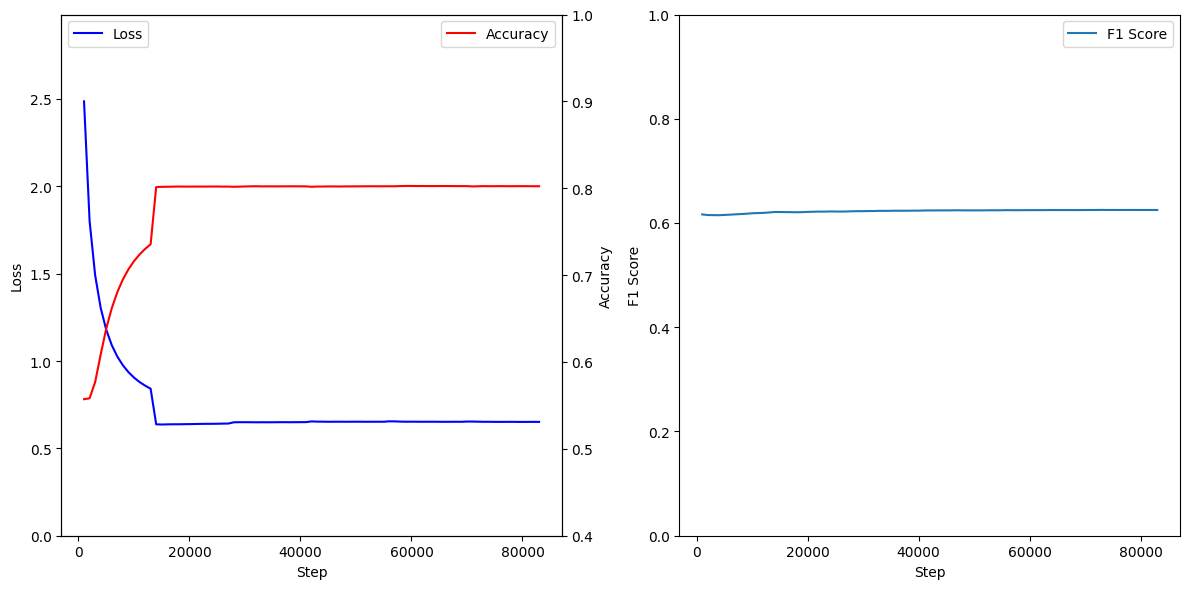

In [32]:
LEARNING_RATE = 0.001
word2vec_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

print(f"hyperparameters:\n Embed Size:\t{EMBEDDING_DIM}\n Learning Rate:\t{LEARNING_RATE}\n Batch Size:\t{BATCH_SIZE}\n Weight Decay:\t{WEIGHT_DECAY} \n Random Seed:\t{SEED_VALUE}")

mycallback = CustomCallback(validation_data=(couples_test, labels_test), batch_size=4*BATCH_SIZE, patience=10, model_save_path='Word2Vec')

word2vec_model.fit(train_dataset, epochs=6, callbacks=[mycallback])

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.3 [7 points] Post-training analysis**
    
This segment involves some simple analysis of your trained embeddings.


    
**1.3.1** - Vector Algebra on Embeddings

Assuming you have chosen a sufficiently large `vocab_size`, find the embeddings for:
    
1. King
2. Male
3. Female
4. Queen
    
Find the vector `v = King - Male + Female` and find its `cosine_similarity()` with the embedding for 'Queen'.
You can use the `cosine_similarity()` function defined in the session 3 exercise.

**NOTE**:The `cosine_similarity()` value, must be greater than `0.9`; If it is not, this implies that your word2vec embeddings are not well-trained.

Write a function `most_similar()`, which finds the top-n words most similar to the given word. Use this function to find the words most similar to `king`.
    <br />
    <br />
    
**Conceptual Question** Why can't we use `cosine_similarity()` as a `loss_function`?
    
<br />
    
</div>

In [33]:
# Specify the path to the directory where the model was saved
model_path = "Word2Vec"

# Load the model
trained_word2vec_model = load_model(model_path)

# objects = pickle.load(open('word2vec_dataset_vsize_3000.pkl', 'rb'))
# # data = objects['data']
# # count = objects['count']
# dictionary = objects['dictionary']
# reverse_dictionary = objects['reverse_dictionary']
# vocab_size = objects['vocab_size']

# del objects

In [19]:
def get_embeddings(word, dictionary, word2vec_model=None, mode='center'):
    assert mode in ['center', 'context']
    assert word in dictionary
    assert word2vec_model is not None
    
    if mode == 'center':
        total_embedding = word2vec_model.center_embedding.get_weights()[0]
    if mode == 'context':
        total_embedding = word2vec_model.context_embedding.get_weights()[0]
    
    return total_embedding[dictionary[word], :]

In [34]:
# Your code here
# find the embedding of the word "king"
trained_embeddings = {}
for word in ['king', 'queen', 'male', 'female']:
    trained_embeddings[word] = get_embeddings(word, dictionary, trained_word2vec_model, mode='center')

In [35]:
v = trained_embeddings['king'] - trained_embeddings['male'] + trained_embeddings['female']

# from sklearn.metrics.pairwise import cosine_similarity

similarity = np.dot(trained_embeddings['queen'], v) / (np.linalg.norm(trained_embeddings['queen']) * np.linalg.norm(v))

print(f"the similarity between the vector [king-male+female] and the vector [queen] is {similarity}")

the similarity between the vector [king-male+female] and the vector [queen] is 0.9943400621414185


In [20]:
def most_similar(top_k, query, word2vec_model, dictionary, reverse_dictionary):
    total_embeddings = word2vec_model.center_embedding.weights[0].numpy()
    # query_id = dictionary[query]
    query_embedding = get_embeddings(query, dictionary, word2vec_model, mode='center')
    similarities = cosine_similarity(total_embeddings, query_embedding.reshape(1, -1))
    # flatten the similarities array and get the indices of the top_k elements
    sorted_indices = np.argsort(similarities.flatten())[::-1][:top_k+1]
    
    # get the top_k words from the reverse dictionary
    top_k_words = [reverse_dictionary[i] for i in sorted_indices]
    
    if query in top_k_words:
        top_k_words.remove(query)
    else:
        top_k_words = top_k_words[:-1]
    return top_k_words

In [36]:
most_similar(5, query='king', word2vec_model=trained_word2vec_model, dictionary=dictionary, reverse_dictionary=reverse_dictionary, )

['peter', 'frederick', 'stephen', 'smith', 'walter']

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

    
**1.3.2** - Visualizing Embeddings

Find the embeddings for the words:
1. 'January'
2. 'February'
3. 'March'
4. 'April'
    
Find the `cosine_similarity()` of 'january' with each of 'february`, 'march', 'april' (which should be high values).
    
Save your trained weights. Recreate the network you have created above and initialize it with random weights. Compute the `cosine_similarity()` values. The values should be small (because the embeddings are random).
    
Use a demonstrative plot to show the `before & after` of the 4 embeddings. Here are some suggestions:
    1. PCA/TSNE for dimensionality reduction
    2. Radar plot to show all embedding dimensions
    
Bonus points for using creative means to demonstrate how the embeddings change after training.

Here is a [video](https://youtu.be/VDl_iA8m8u0) of a sample demonstration. We used a custom callback to get embeddings during training.  
            
</div>

In [37]:
trained_embeddings = {}
for word in ['january', 'february', 'march', 'april']:
    trained_embeddings[word] = get_embeddings(word, dictionary, trained_word2vec_model, mode='center')

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

for word in ['february', 'march', 'april']:
    cos_sim = cosine_similarity(trained_embeddings['january'].reshape(1,-1), trained_embeddings[word].reshape(1,-1))
    print(f"the similarity between 'january' and '{word}' is:\t {cos_sim}")

the similarity between 'january' and 'february' is:	 [[0.99681234]]
the similarity between 'january' and 'march' is:	 [[0.99404454]]
the similarity between 'january' and 'april' is:	 [[0.99438703]]


In [41]:
vanilla_word2vec_model = Word2Vec(vocab_size=5000, embedding_dim=128) # this is an untrained model
vanilla_word2vec_model.build(input_shape=(None, 2))

random_embeddings = {}
for word in ['january', 'february', 'march', 'april']:
    random_embeddings[word] = get_embeddings(word, dictionary=dictionary, word2vec_model=vanilla_word2vec_model)

print("RANDOM embedding:")
for word in ['february', 'march', 'april']:
    cos_sim = cosine_similarity(random_embeddings['january'].reshape(1,-1), random_embeddings[word].reshape(1,-1))
    print(f"the similarity between 'january' and '{word}' is \t {cos_sim}")

RANDOM embedding:
the similarity between 'january' and 'february' is 	 [[-0.08916321]]
the similarity between 'january' and 'march' is 	 [[-0.05821669]]
the similarity between 'january' and 'april' is 	 [[0.07127798]]


In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from math import pi

# Define a function to create a radar chart
def create_radar_chart(data, ax, colors= ['b', 'r', 'g', 'y'], names=['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4'], title=""):
    num_vars = len(data[0])
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    for idx, color in enumerate(colors):
        values = data[idx].tolist()
        values += values[:1]

        ax.fill(angles, values, color=color, alpha=0.25)
        ax.plot(angles, values, color=color, linewidth=2, label=names[idx])

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(range(1, num_vars + 1))
    ax.set_title(title)

    ax.legend()

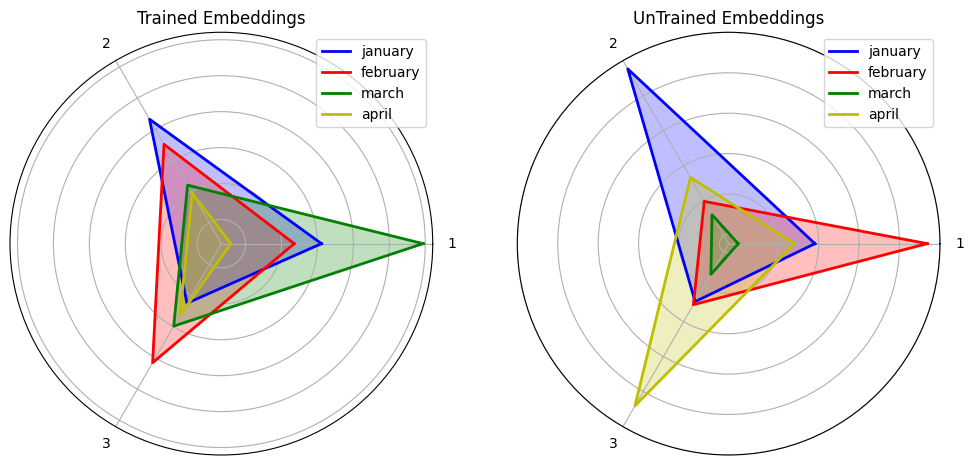

In [43]:
word_list = list(trained_embeddings.keys())
pca = PCA(n_components=3)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))
embedding_list = list(trained_embeddings.values())
data_pca = pca.fit_transform(embedding_list)
create_radar_chart(data_pca, axs[0], names=word_list, title="Trained Embeddings")

embedding_list = list(random_embeddings.values())
data_pca = pca.fit_transform(embedding_list)
create_radar_chart(data_pca, axs[1], names=word_list, title="UnTrained Embeddings")

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.3.3** - Embedding and Context Matrix
    
    
**1.3.3.1** Investigate the relation between the Embedding & Context matrix. Again use the `cosine_similarity()` function to find the average value across all the words in the embedding and context matrix, i.e:
  - For the word 'dog', find the embedding value, and context value. <br>
  - Calculate the `cosine_similarity()` between the two <br>
  - Repeat the same for every word in the vocabulary and calculate the average value of the `cosine_similarity()`
<br />

**1.3.3.2** Answer the following question and explain:

**Question:** The embedding and context matrices should be identical.
<br />
    
</div>

In [44]:
dog_embedding_value = get_embeddings(word='dog', dictionary=dictionary, word2vec_model=trained_word2vec_model, mode='center')
dog_context_value = get_embeddings(word='dog', dictionary=dictionary, 
                                   word2vec_model=trained_word2vec_model,
                                   mode='context')

print(f"the simlarity between the center embedding and context embedding of [dog] is {cosine_similarity(dog_embedding_value.reshape(1,-1), dog_context_value.reshape(1, -1))}")

the simlarity between the center embedding and context embedding of [dog] is [[0.95839274]]


In [45]:
# get the weight 
total_center_embedding_weight = trained_word2vec_model.center_embedding.weights[0].numpy()
total_context_embedding_weight = trained_word2vec_model.context_embedding.weights[0].numpy()

total_cosine_similarity = []
for i in range(len(total_center_embedding_weight)):
    norms = np.linalg.norm(total_center_embedding_weight[i])*np.linalg.norm(total_context_embedding_weight[i])
    if norms == 0:
        continue
    sim = np.dot(total_center_embedding_weight[i], total_context_embedding_weight[i])/norms
    total_cosine_similarity.append(sim)
print("The average cosine similarity is: ", np.mean(total_cosine_similarity))

The average cosine similarity is:  0.9664029


ANSWER:

The embedding and context matrices are usually not identical because they are updated differently during training.

For the embedding matrix, the weights are adjusted based on the error in predicting the context words from the input word. For the context matrix, the weights are adjusted based on the error in predicting the input word from the context words.

And they represent different meanings, one for the center/target, and one for context/ background

But in our senario, we find the center and context resembles much, which might be attributed to the overfitting on a small amount of data

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.4 [5 points] Learning phrases**
    
As per the original paper by [Mikolov et al](https://arxiv.org/abs/1301.3781) many phrases have a meaning that is not a simple composition of the meanings of their individual words.
For eg. `new york` is one entity, however, as per our analysis above, we have two separate entities `new` & `york` which can have different meanings independently.    
To learn vector representation for phrases, we first find words that
appear frequently together, and infrequently in other contexts.
    
As per the analysis in the paper, we can use a formula to rank commonly used word pairs, and take the first 100 commonly occurring pairs.
$$\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}$$

**NOTE:** For simplicity of analysis, we take the discounting factor $\delta$ as 0, and take bi-gram combinations. You can experiment with tri-grams for word pairs such as `New_York_Times`.     
    
</div>

**1.4.1** - Find 100 most common bi-grams

From the tokenized data above, find the count for each bigram pair.
    
For each such pair, find the score associated with each token pair using the formula above.
    
 Pick the top 100 pairs based on the score. (Higher the better). To understand the `score()` function we suggest you read the paper mentioned above.
    
Replace the original `text8` file with the pairs as one entity. E.g., if `prime, minister` is a commonly occurring pair, replace `... prime minister ...' in the original corpus with a single entity `prime_minister`. Do this for all 100 pairs.

In [4]:
# # Get the training data again
# filename = 'text8.zip'
# with zipfile.ZipFile(filename) as f:
# # Read the data into a list of strings.
#     super_text = tf.compat.as_str(f.read(f.namelist()[0]))
    
# # Make sure to use lower case and split as before
# corpus = super_text.lower().split()
# data, count, dictionary, reversed_dictionary = build_dataset(corpus,n_words=3000)

# Or just load the data we saved in Part 1

objects = pickle.load(open('tokenized_data_vocab_3000.pkl', 'rb'))
corpus = objects['data']
count = objects['count']
dictionary = objects['dictionary']
reverse_dictionary = objects['reverse_dictionary']
vocab_size = objects['vocab_size']

del objects

In [5]:
# count the bigram occurences in the corpus
bigram_occurences = defaultdict(int)

for i in tqdm(range(1, len(corpus))):
    if len(corpus[i]) == 0 or len(corpus[i-1]) == 0:
        continue
    bigram_occurences[(corpus[i-1][0], corpus[i][0])] += 1

100%|██████████| 17005206/17005206 [00:06<00:00, 2629130.13it/s]


In [6]:
scores = defaultdict(float)
for key, value in bigram_occurences.items():
    scores[key] = value / (count[reverse_dictionary[key[0]]] * count[reverse_dictionary[key[1]]])
    
# get the highest 100 scores
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
sorted_scores = dict(sorted_scores)

In [7]:
from prettytable import PrettyTable

table = PrettyTable(title = "Top N Bigrams")
table.field_names = [" ","Words", "Score"]
print_i = 0
for bigram, score in sorted_scores.items():
    words = [reverse_dictionary[bigram[0]], reverse_dictionary[bigram[1]]]
    if words == ['united', 'kingdom']:
        table.add_row([print_i+1, ' '.join(words), f"{score:.6f}"])
        break
    # if count[words[0]] > 10000 or count[words[1]] > 10000:
    if print_i % 50 == 0:
        table.add_row([print_i+1, ' '.join(words), f"{score:.6f}"])
    print_i += 1

print(table)

+----------------------------------------+
|             Top N Bigrams              |
+-----+-----------------------+----------+
|     |         Words         |  Score   |
+-----+-----------------------+----------+
|  1  |        hip hop        | 0.001068 |
|  51 |      lie algebra      | 0.000129 |
| 101 |    federal reserve    | 0.000096 |
| 151 |      jean pierre      | 0.000074 |
| 201 |       aids adult      | 0.000063 |
| 251 |      gary indiana     | 0.000056 |
| 301 |     studio albums     | 0.000051 |
| 351 |      listed below     | 0.000046 |
| 401 | international airport | 0.000042 |
| 451 |    lords spiritual    | 0.000040 |
| 468 |     united kingdom    | 0.000038 |
+-----+-----------------------+----------+


We manually extend the dictionary and reverse_dictionary by 500, which will include the "united kingdom"

In [10]:
# we slice the dictionary and reverse_dictionary to vocabulary_size (3000)

i = 0
new_dict = {}
new_reverse_dict = {}
for dict_i, dict_r_i in zip(dictionary.items(), reverse_dictionary.items()):
    assert dict_i[0] == dict_r_i[1] and dict_i[1] == dict_r_i[0]
    i += 1
    new_dict[dict_i[0]] = dict_i[1]
    new_reverse_dict[dict_r_i[0]] = dict_r_i[1]
    if i >= vocab_size - 1:
        break

In [11]:
# to make "united kingdom" work, we set the bigram num to 500
top_500_bigrams = []
i = 0 
for bigram, score in sorted_scores.items():
    top_500_bigrams.append(bigram)
    words = new_reverse_dict[bigram[0]] + '_' + new_reverse_dict[bigram[1]]
    new_dict[words] = vocab_size + i
    new_reverse_dict[vocab_size + i] = words
    if i == 499:
        break
    i += 1
new_vocab_size = 3500

In [12]:
# print some words and their indices to see if our dictionaries are working
for i in range(3000, 3005):
    print(i, ":", new_reverse_dict[i], '\t', new_reverse_dict[i], ':', new_dict[new_reverse_dict[i]])

3000 : hip_hop 	 hip_hop : 3000
3001 : los_angeles 	 los_angeles : 3001
3002 : hong_kong 	 hong_kong : 3002
3003 : super_bowl 	 super_bowl : 3003
3004 : mac_os 	 mac_os : 3004


In [120]:
# build a new corpus with bigrams

new_corpus = []
len_corpus = len(corpus)
i = 0 
while i < len_corpus - 1:
    while len(corpus[i]) == 0 or len(corpus[i+1]) == 0: # clear the oov words
        i += 1
        new_corpus.append(new_vocab_size)
        continue
    if (corpus[i][0], corpus[i+1][0]) in top_500_bigrams: # replace the separated words with bigrams
        word = new_reverse_dict[corpus[i][0]] + '_' + new_reverse_dict[corpus[i+1][0]]
        new_corpus.append(new_dict[word])
        i += 2
        continue
    else:
        new_corpus.append(corpus[i][0])
        i += 1

In [122]:
# saved_objects = {
#     'corpus': new_corpus,
#     'vocab_size': new_vocab_size,
#     'dictionary': new_dict,
#     'reverse_dictionary': new_reverse_dict,
# }

# with open('bigram_corpus_vocab_3500', 'wb') as f:
#     pickle.dump(saved_objects, f)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.4.2** - Retrain word2vec   
With the new corpus generated as above, build the dataset, use skipgrams and retrain your word2vec with a sufficiently large vocabulary.

Write a function `most_dissimilar()`, similar to the `most_similar()` function, however this finds the top-n words which are **most dissimilar** to the given word.
Use this function defined above to find the entities most dissimilar to `united_kingdom`
    
Compare the above with separate tokens for `united` & `kingdom` and the sum of the vectors (to get this, you may need a sufficiently large vocabulary (>2000).
<br />

</div>

###### Some miscellaneous steps, same as 1.1 and 1.2

In [124]:
# we do the same process as 1.2
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(new_vocab_size+1)
couples, labels = tf.keras.preprocessing.sequence.skipgrams(
    sequence=new_corpus,
    vocabulary_size=new_vocab_size+1,
    window_size=3,
    sampling_table=sampling_table,
)

# delete the oov sample, which is the id==VOCAB_SIZE
new_couples = []
new_labels = []

for couple, label in tqdm(zip(couples, labels), total=len(couples)):
    if couple[0] == new_vocab_size or couple[1] == new_vocab_size:
        continue
    else:
        new_couples.append(couple)
        new_labels.append(label)
        
print('num of train samples before deleting oov sample: ', len(couples))
print('num of train samples after deleting oov sample: ', len(new_couples))

100%|██████████| 56126610/56126610 [00:23<00:00, 2340244.96it/s]

num of train samples before deleting oov sample:  56126610
num of train samples after deleting oov sample:  12147285


In [126]:
### save and load

# saved_objects = {
#     "couples": np.array(new_couples, dtype=np.int16),
#     "labels": np.array(new_labels, dtype=np.bool_),
#     "reverse_dictionary": new_reverse_dict,
#     "dictionary": new_dict,
#     "vocab_size": new_vocab_size,
# }

# with open(f'bigram_word2vec_dataset_vsize_{new_vocab_size}.pkl', 'wb') as f:
#     pickle.dump(saved_objects, f)
# del saved_objects

# saved_objects = pickle.load(open('bigram_word2vec_dataset_vsize_3500.pkl', 'rb'))

# couples = saved_objects["couples"]
# labels = saved_objects["labels"]
# reverse_dictionary = saved_objects["reverse_dictionary"]
# dictionary = saved_objects["dictionary"]
# vocab_size = saved_objects["vocab_size"]
# print(len(couples), 'vocab size', vocab_size)

In [7]:
SEED_VALUE = 42
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

couples_train, couples_test, labels_train, labels_test = train_test_split(couples, labels, test_size=0.1, random_state=SEED_VALUE)

BATCH_SIZE = 1024

couples_train = tf.constant(couples_train)
labels_train = tf.constant(labels_train)
print(f'TRAIN shape of couples: {couples_train.shape}, shape of labels: {labels_train.shape}')

train_dataset = tf.data.Dataset.from_tensor_slices((couples_train, labels_train))
train_dataset = train_dataset.shuffle(buffer_size=8*BATCH_SIZE, seed=SEED_VALUE).batch(BATCH_SIZE, drop_remainder=True)

couples_test = tf.constant(couples_test)
labels_test = tf.constant(labels_test)
print(f'VALIDATION shape of couples: {couples_test.shape}, shape of labels: {labels_test.shape}')

TRAIN shape of couples: (10932556, 2), shape of labels: (10932556,)
VALIDATION shape of couples: (1214729, 2), shape of labels: (1214729,)


###### Train bigram word2vec model

Model: "word2_vec_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_embedding (Embedding  multiple                 336000    
 )                                                               
                                                                 
 context_embedding (Embeddin  multiple                 336000    
 g)                                                              
                                                                 
 dot_1 (Dot)                 multiple                  0         
                                                                 
Total params: 672,000
Trainable params: 672,000
Non-trainable params: 0
_________________________________________________________________
hyperparameters:
 Embed Size:	96
 Learning Rate:	0.001
 Batch Size:	1024
 Weight Decay:	0.0001 
 Random Seed:	42
Epoch 1/6


    1/10676 [..............................] - ETA: 1:12:35 - loss: 4.4311 - accuracy: 0.5840

2023-08-03 10:10:08.388912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  996/10676 [=>............................] - ETA: 1:08 - loss: 2.4704 - accuracy: 0.5912

2023-08-03 10:10:15.651242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: Word2Vec_birgam/assets

 F1 score improved to 0.6048, saving model to Word2Vec_birgam

10676/10676 [==============================] - 79s 7ms/step - loss: 0.8889 - accuracy: 0.7330 - validation_f1: 0.5996
Epoch 2/6
  321/10676 [..............................] - ETA: 1:07 - loss: 0.6262 - accuracy: 0.8141INFO:tensorflow:Assets written to: Word2Vec_birgam/assets

 F1 score improved to 0.6048, saving model to Word2Vec_birgam

 1319/10676 [==>...........................] - ETA: 1:09 - loss: 0.6323 - accuracy: 0.8135 - validation_f1: 0.6048INFO:tensorflow:Assets written to: Word2Vec_birgam/assets

 F1 score improved to 0.6062, saving model to Word2Vec_birgam

 2322/10676 [=====>........................] - ETA: 1:02 - loss: 0.6332 - accuracy: 0.8135 - validation_f1: 0.6055INFO:tensorflow:Assets written to: Word2Vec_birgam/assets

 F1 score improved to 0.6071, saving model to Word2Vec_birgam

 3321/10676 [========>.....................] - ETA: 55s - loss: 0.

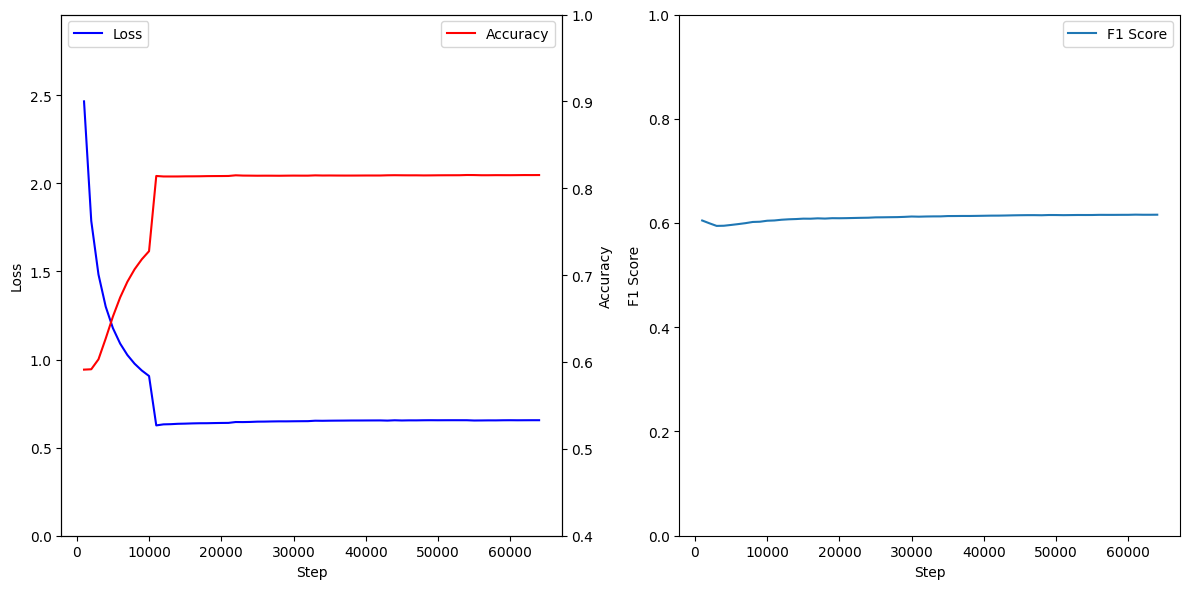

In [11]:
EMBEDDING_DIM = 96
WEIGHT_DECAY = 1e-4

word2vec_bigram_model = Word2Vec(vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM, weight_decay=WEIGHT_DECAY)

word2vec_bigram_model.build(input_shape=(None, 2))

word2vec_bigram_model.summary()


LEARNING_RATE = 0.001
word2vec_bigram_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

print(f"hyperparameters:\n Embed Size:\t{EMBEDDING_DIM}\n Learning Rate:\t{LEARNING_RATE}\n Batch Size:\t{BATCH_SIZE}\n Weight Decay:\t{WEIGHT_DECAY} \n Random Seed:\t{SEED_VALUE}")

mycallback = CustomCallback(validation_data=(couples_test, labels_test), batch_size=4*BATCH_SIZE, patience=20, model_save_path='Word2Vec_birgam')

word2vec_bigram_model.fit(train_dataset, epochs=6, callbacks=[mycallback])

###### most dissimilar and united_kingdom v.s. united+ kingdom

In [17]:
def most_dissimilar(top_k, query, word2vec_model, dictionary, reverse_dictionary):
    total_embeddings = word2vec_model.center_embedding.weights[0].numpy()
    query_embedding = get_embeddings(query, dictionary, word2vec_model, mode='center')
    
    # Calculate the cosine similarities
    similarities = cosine_similarity(total_embeddings, query_embedding.reshape(1, -1))
    
    # Calculate the cosine distances
    distances = 1 - similarities
    
    # Flatten the distances array and get the indices of the top_k elements
    sorted_indices = np.argsort(distances.flatten())[::-1][:top_k]
    
    # Get the top_k words from the reverse dictionary
    top_k_words = [reverse_dictionary[i] for i in sorted_indices]
    
    return top_k_words

In [20]:
most_dissimilar(5, "united_kingdom", word2vec_bigram_model, dictionary, reverse_dictionary)

['looking_glass',
 'coach_mike',
 'brian_wilson',
 'record_label',
 'angeles_california']

In [28]:
embedding_united = get_embeddings("united", dictionary, word2vec_bigram_model)
embedding_kingdom = get_embeddings("kingdom", dictionary, word2vec_bigram_model)

embedding_sum = embedding_kingdom + embedding_united

embedding_uk = get_embeddings("united_kingdom", dictionary, word2vec_bigram_model)

print(f"the similarity is between 'united' + 'kingdom' and 'united_kingdom' is {cosine_similarity(embedding_sum.reshape(1, -1), embedding_uk.reshape(1, -1))}")

the similarity is between 'united' + 'kingdom' and 'united_kingdom' is [[0.99102867]]


## **PART 2 [64 points]: IMDB Sentiment Analysis using ELMo**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
   
Sentiment analysis, also known as opinion mining or emotion AI, is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.
    
For this part of the homework, we will be using the IMDB dataset, which is publicly available [here](http://ai.stanford.edu/~amaas/data/sentiment/).    

This represents a "many-to-one" problem, with the output classified as a `positive` or `negative` sentiment, depending on the words used in the review.
    
    
In the first part of this section, you are expected to build a language model to train a basic ELMo.
    
Although the original ELMo implementation uses *Character Embeddings*, for the sake of this homework, we will use word embeddings instead.
    
Read more about the ELMo paper [here](https://arxiv.org/pdf/1802.05365.pdf).

In the second part of this subsection, you will use the generated ELMo embeddings in a deep-learning model to perform sentiment analysis using the IMDB dataset.
    
You will compare its performance, with a baseline model without any trained embeddings, and another model which directly uses the `word2vec` embeddings.

<br />
    </div>

### **PART 2: Questions**    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

 **2.1 [15 points] Preprocess the dataset**
<br />

<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occurring words.
- Limit the largest review to a maximum of 200 words only.
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which have to be corrected. A helper code is provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end-of-sentence token \<\/s>.

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"
<br />

**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file can be downloaded from [here](https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz) and can be accessed like a dictionary.
    
**NOTE**: To access the pre-trained embeddings, [gensim](https://pypi.org/project/gensim/) library can be used.

Check if the embeddings for the start token (\<s\>) and end token (\</s\>) are present in the loaded `word2vec` embeddings.

Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors if they are not present.

Create an `embedding_matrix` that will consist of the words present in word2vec. It will be a matrix of dimension `num_words X embedding_dim` `(5000 X 300)` including the addition of start and end tokens.
<br /><br />
**2.1.3** Prepare data for model training:

- Not all the words in the reviews are present in the embeddings file. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
```

- Split the data (`x_train` (tokens list), `y_train` (class list)) into 80% training and 20% validation. We will use the `y_train` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.

</details>
<br />
    
**2.2 [34 points] Define and train the model**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis.
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpora.  

**2.2.1** Build a `tf.data.Dataset` for training, and another one for validation

- Set an appropriate batch size (32, 64, 128, 256,...) This value will be determined by the GPU you have.

- Set `train_shuffle_buffer_size` and `validation_shuffle_buffer_size` to the length of training data and validation data respectively

- `tf.data.Dataset` is an efficient way to build data pipelines. Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes fewer resources, which is optimal for training.

- Hint: When creating tf.data.Dataset use `tf.ragged.constant` to convert your ragged tokens to ragged tensors

- `dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. It can be set to `num_parallel_calls=AUTOTUNE`. You will use the `transform_pad` function to perform model-specific data processing.

- When building the tf.data pipeline use the following order:
  - shuffle
  - batch
  - map
  - prefetch
<br>
<br>
- After you build your train and validation dataset, use `dataset.take(1)` to view the first row of data from the training dataset. It is important to verify the data input and output dimensions before modelling
<br /><br />
    
**2.2.2** Building the language model
    
*Transform Input within the model:*

*   In forward LSTM, we use the n-th token to predict the (n+1)-th token. Hence we want to discard the last one, the end of sentence token, `</s>`, from all the sentences. Remember all the sentences are padded, so the `</s>` will not be the last element of the sequence.

   * One way of achieving that is, using a Boolean mask with help of [tf.sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) or with the help of [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd), which can be used to select specific elements from a tensor based on their indices. Remember you can combine multiple boolean masks via multiple logic operations. We also encourage you to come up with your solutions.
   * Note that after using boolean masks your outputs will be flattened out and you have to reshape them back with the appropriate batch size. Remember that you removed the end of sentence token, hence the length of the sequence would be length-1.

    
![](https://drive.google.com/uc?export=view&id=1f5bPplDGlRUdfii5X1bD2kd20SKRyOSo)
  

* For the backward LSTM layers, the next word prediction task is doing the reverse of what it was doing for the forward LSTM layers. We aim to predict the n-th token with the (n+1)-th token. To achieve this we remove the start of the sentence token `<s>` from all the sentences.


The model's inputs should be followed by a `tf.keras.layers.Embedding()` layer. The `Embedding` layer will act as a lookup table to convert token inputs to their corresponding word2vec values. When initialising the `Embedding` layer, set the layer weights with the `embedding_matrix` you had built in the previous question.

Set the trainable to false and mask_zero to true in the `Embedding` layer. The input dimension should be the number of rows in `embedding_matrix` and the output dimension should be your embedding dimension of `300`.
    
Refer to this image from the lecture slides on ELMo.
    
    
![](https://drive.google.com/uc?export=view&id=1fNPnrBR7Wfh_Jci70QaHde1L3nTcs9-D)
    
*go_backwards in backward LSTM layers*

* To predict the words backwards, we will use the go_backwards parameter present in the TensorFlow LSTM layer implementation. Remember to reverse the output of each backward LSTM layer before using it. Refer to the documentation of [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Remember to invert the sequence dimension and not the embedding dimension.

Remember to use the **same** *softmax* layer on both the forward and the backward LSTMs.
    
This will give you an `output_f` and `output_b` which you will evaluate with your two targets.  

$$L = -\sum y \cdot log(\widehat{y}_{right}) -\sum y \cdot log(\widehat{y}_{left})$$

Use an appropriate loss function, and optimizer and train the network sufficiently.   

Finally, plot the training history of the train and validation loss.
<br />
    
**NOTE**: Use native tensorflow functions like `tf.shape` instead of numpy functions like `np.shape`.
<br />  

**2.2.3** Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings.

*To concatenate the forward and backward LSTM hidden states we have to align them, which will be achieved by removing the start and end of sentence token embeddings from the forward and the backwards LSTM hidden states respectively. You can use the same logic that you used to process the input. It is necessary to reverse the output of the backward LSTM layers before using it in the Toy ELMo model.*

The obtained embeddings should be:
    
1. The `word2vec` embeddings
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings

    This will be the concatenation of the first LSTM layers of the language model (`lstm1 forward + lstm1 backwards`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`lstm2 forward + lstm2 backwards`).    
    
- Make a test prediction of your `Toy_ELMo` model  

</details>
    
<br />
    
 **2.3 [15 points] Transfer Learning**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a downstream task such as sentiment analysis.
    
**2.3.1** - Baseline model:
    
For the baseline model, you will use:

- `tf.keras.Layers.Embedding()` layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
You will build a `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). Unlike in 2.2.1 we only need a single sequence of tokens for this model

Train it for sufficient epochs using an appropriate optimizer and learning rate.

**2.3.2** - Directly using pre-trained `word2vec`:
    
For this section, use the pre-trained `word2vec` embeddings directly into your model.

You can use the same `tf.data.Dataset` from 2.3.1 for this model
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.
    <br /><br />
**2.3.3** - You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.  

Using ELMo embeddings:

You will build another `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). This model also requires two inputs one for forward and one for backward LSTM.   

For this model, you will use:
- `Toy_ELMo` model after the input layer
-  Sauce layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model.
        
Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

$$ELMo_{t} = \gamma \sum_{j=0}^{L} s_{j} h_{t}^{j}$$
    
Since we are not using any other embeddings, we will set the value of $\gamma$ to 1. <br>
Train the modified model sufficiently, and compare it to the previously trained models.
</details>
</div>

### **PART 2: Solutions**    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">



#### **2.1 [15 points] Preprocess the dataset**
</div>


**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occurring words.
- Limit the largest review to a maximum of 200 words only.
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which have to be corrected. A helper code is provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end-of-sentence token \<\/s>.

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"

In [9]:
# Your code here
### Helper code to fix the mapping of the imdb word index

index = tf.keras.datasets.imdb.get_word_index()

# we need to add 3 from the indices because 0 is 'padding', 1 is 'start of sequence' and 2 is 'unknown'

inv_index = {j+3:i for i,j in index.items()}

# Tags for start and end of sentence

inv_index[1] = '<s>'
inv_index[2] = 'UNK'
inv_index[3] = '</s>'

index = {j:i for i,j in inv_index.items()}

In [10]:
# Your code here
from tensorflow.keras.datasets import imdb

#Load
num_words=5000
maxlen = 200
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words, maxlen=maxlen)

In [11]:
# Add '</s>' to the end of each sequence
train_data = [sequence + [index['</s>']] for sequence in train_data]
test_data = [sequence + [index['</s>']] for sequence in test_data]

In [9]:
#Dict of train and test set
train_dict = {}
for i in range(len(train_data)):
    train_dict[tuple(train_data[i])] = train_labels[i]


test_dict = {}
for i in range(len(test_data)):
    train_dict[tuple(test_data[i])] = test_labels[i]

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file can be downloaded from [here](https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz) and can be accessed like a dictionary.
    
**NOTE**: To access the pre-trained embeddings, [gensim](https://pypi.org/project/gensim/) library can be used.

Check if the embeddings for the start token (\<s\>) and end token (\</s\>) are present in the loaded `word2vec` embeddings.

Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors if they are not present.

Create an `embedding_matrix` that will consist of the words present in word2vec. It will be a matrix of dimension `num_words X embedding_dim` `(5000 X 300)` including the addition of start and end tokens.
<br />

</div>

In [9]:
# Obtaining Word2Vec embeddings using gensim library
import gensim.downloader as api

model = api.load("word2vec-google-news-300")

[=-------------------------------------------------] 2.7% 44.7/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
#</s> is in it, <s> is not
vector_rand=0.1*np.random.rand(300)-0.05
model.add_vectors('<s>', vector_rand)
np.save('Part_2/vector_rand.npy', vector_rand)

In [ ]:
#To find the Top-5000 words
sorted_word_index = sorted(index.items(), key=lambda x: x[1])
top_words = [word for word, index in sorted_word_index[:num_words]]

#Get the matrix, if the word is not exist in word2vec, its embeding remains in 0
embedding_matrix = np.zeros((num_words,300))
embedding_dim=300
for word in top_words:
  Temp= top_words.index(word)
  try:
    embedding_vector = model[word]
    embedding_matrix[Temp] = embedding_vector
  except KeyError:
    embedding_matrix[Temp] = np.zeros(embedding_dim)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
        
    
**2.1.3** - Prepare data for model training:

- Not all the words in the reviews are present in the embeddings file. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
```

- Split the data (`x_train` (tokens list), `y_train` (class list)) into 80% training and 20% validation. We will use the `y_train` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.
</div>

In [ ]:
# Your code here
for word in top_words:
    if i < num_words+3:
        try:
            embedding_vector = model[word]
        except KeyError:
            # Remove the integer value fromtraining sequence
            for j in range(len(train_data)):
             train_data[j] = [data for data in train_data[j] if data != word]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
#### **2.2 [34 points] Define and train the model**
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis.
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpora.  
</div>


**2.2.1** - Build a `tf.data.Dataset` for training, and another one for validation

- Set an appropriate batch size (32, 64, 128, 256,...) This value will be determined by the GPU you have.

- Set `train_shuffle_buffer_size` and `validation_shuffle_buffer_size` to the length of training data and validation data respectively

- `tf.data.Dataset` is an efficient way to build data pipelines. Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes fewer resources, which is optimal for training.

- Hint: When creating tf.data.Dataset use `tf.ragged.constant` to convert your ragged tokens to ragged tensors

- `dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. It can be set to `num_parallel_calls=AUTOTUNE`. You will use the `transform_pad` function to perform model-specific data processing.

- When building the tf.data pipeline use the following order:
  - shuffle
  - batch
  - map
  - prefetch
<br><br>
- After you build your train and validation dataset, use `dataset.take(1)` to view the first row of data from the training dataset. It is important to verify the data input and output dimensions before modelling

In [6]:
saved_objects = pickle.load(open('Data_train.pkl', 'rb'))
x_train = saved_objects['x_train']
x_val = saved_objects['x_val']
y_train = saved_objects['y_train']
y_val = saved_objects['y_val']

In [5]:
tokens_list_train = x_train
tokens_list_val = x_val

In [6]:
# Helper Code
batch_size = 64
train_shuffle_buffer_size = len(tokens_list_train)
validation_shuffle_buffer_size = len(tokens_list_val)

# Fill the required cells to complete the function
def transform_pad(input, output, n):

    # You will  transform the input at the run time
    input = input.to_tensor(default_value=0, shape=[None, None])

    # Transform the output for the f and b LSTM
    output_f = output[:,1:]
    output_b = output[:,:-1]


    # Pad the outputs
    output_f = output_f.to_tensor(default_value=0, shape=[None, None])
    output_b = output_b.to_tensor(default_value=0, shape=[None, None])

    return (input,n),(output_f, output_b)
    # return input, (output_f, output_b)

# Calculate and store length of each sentence
N_train = [len(n) for n in tokens_list_train]
N_val = [len(n) for n in tokens_list_val]

N_train = tf.constant(N_train, tf.int32)
N_val = tf.constant(N_val, tf.int32)

# Use tensorflow ragged constants to get the ragged version of data
train_processed_x = tf.ragged.constant(tokens_list_train)
validate_processed_x = tf.ragged.constant(tokens_list_val)
train_processed_y = tf.ragged.constant(tokens_list_train)
validate_processed_y = tf.ragged.constant(tokens_list_val)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y,N_train))
validation_data = tf.data.Dataset.from_tensor_slices((validate_processed_x, validate_processed_y,N_val))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
#validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)))>
validation_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)))>


In [7]:
# View some data from tf dataset
for (input_f,n) ,(output_f, output_b) in train_data.take(1):
  print(input_f.shape)
  print(input_f[0])
  print(n.shape)
  print(n[0])
  print("************************")
  print(output_f.shape,output_b.shape)
  print(output_f[0])
  print(output_b[0])

(64, 199)
tf.Tensor(
[   1   13  219   35 4677 2824   18   14   20 4487   13  427  447   12
    4   20  828   72   23    4 1289    7   61 2224   32  314    2 2693
    9  576  948   17    4 1019   18  148    7   25   37   28  110 1354
  778   27  109   16   76    2   11   14   22   29  256   27  109   55
   73    4    2   78  232   13   28  110   11    2 2844    2   16   87
  316   11    4  311 1498    2    5    2   33    4  172   58   17   48
   75   71   23    2    4  836    9 1428  143   46    4   20    4  480
  173    9   15    4  130   16   24 1210    2   13   16   24  685   11
    4  130   13  421 4095    4 1472  127   24   81    4   20 1351    4
   20    9   76  128   74    4 1472    2   81   24  858   18   14   20
    8  216   46   23  374  140   67   12  261   13  122   24   28    8
  990    8   67   14   20   13   62   28    2  348  158    2    8   67
   12  358    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

2023-08-04 15:14:32.678870: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.2.2** - Building the language model
    
*Transform Input within the model:*

*   In forward LSTM, we use the n-th token to predict the (n+1)-th token. Hence we want to discard the last one, the end of sentence token, `</s>`, from all the sentences. Remember all the sentences are padded, so the `</s>` will not be the last element of the sequence.

   * One way of achieving that is, using a Boolean mask with help of [tf.sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) or with the help of [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd), which can be used to select specific elements from a tensor based on their indices. Remember you can combine multiple boolean masks via multiple logic operations. We also encourage you to come up with your solutions.
   * Note that after using boolean masks your outputs will be flattened out and you have to reshape them back with the appropriate batch size. Remember that you removed the end of sentence token, hence the length of the sequence would be length-1.

    
![](https://drive.google.com/uc?export=view&id=1f5bPplDGlRUdfii5X1bD2kd20SKRyOSo)
  

* For the backward LSTM layers, the next word prediction task is doing the reverse of what it was doing for the forward LSTM layers. We aim to predict the n-th token with the (n+1)-th token. To achieve this we remove the start of the sentence token `<s>` from all the sentences.


The model's inputs should be followed by a `tf.keras.layers.Embedding()` layer. The `Embedding` layer will act as a lookup table to convert token inputs to their corresponding word2vec values. When initialising the `Embedding` layer, set the layer weights with the `embedding_matrix` you had built in the previous question.

Set the trainable to false and mask_zero to true in the `Embedding` layer. The input dimension should be the number of rows in `embedding_matrix` and the output dimension should be your embedding dimension of `300`.
    
Refer to this image from the lecture slides on ELMo.
    
    
![](https://drive.google.com/uc?export=view&id=1fNPnrBR7Wfh_Jci70QaHde1L3nTcs9-D)
    
*go_backwards in backward LSTM layers*

* To predict the words backwards, we will use the go_backwards parameter present in the TensorFlow LSTM layer implementation. Remember to reverse the output of each backward LSTM layer before using it. Refer to the documentation of [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Remember to invert the sequence dimension and not the embedding dimension.

Remember to use the **same** *softmax* layer on both the forward and the backward LSTMs.
    
This will give you an `output_f` and `output_b` which you will evaluate with your two targets.     

$$L = -\sum y \cdot log(\widehat{y}_{right}) -\sum y \cdot log(\widehat{y}_{left})$$

Use an appropriate loss function, and optimizer and train the network sufficiently.   

Finally, plot the training history of the train and validation loss.
<br />
    
**Note**: Use native tensorflow functions like `tf.shape` instead of numpy functions like `np.shape`.
<br />  

</div>    

In [24]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class Toy_Elmo(Model):
    def __init__(self, vocab_size, embed_dim, num_units, embedding_matrix=None, return_elmo=False):
        super(Toy_Elmo, self).__init__()
        if embedding_matrix is not None:
            assert embedding_matrix.shape[0] == vocab_size and embedding_matrix.shape[1] == embed_dim
            self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[embedding_matrix])
        else:
            self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.lstm_f1 = LSTM(num_units, return_sequences=True)
        self.lstm_b1 = LSTM(num_units, return_sequences=True, go_backwards=True)
        self.lstm_f2 = LSTM(num_units, return_sequences=True)
        self.lstm_b2 = LSTM(num_units, return_sequences=True, go_backwards=True)
        self.dense_f = Dense(vocab_size, activation='softmax')
        self.dense_b = Dense(vocab_size, activation='softmax')
        self.return_elmo = return_elmo

    def call(self, inputs):
        sequences, sequence_lengths = inputs
        mask = tf.sequence_mask(sequence_lengths)
        word2vec_embeddings = self.embedding(sequences)
        
        lstm_f1_output = self.lstm_f1(word2vec_embeddings, mask=mask)
        lstm_b1_output = self.lstm_b1(word2vec_embeddings, mask=mask)
        
        # skip connections
        lstm_f1_output = lstm_f1_output + word2vec_embeddings
        lstm_b1_output = lstm_b1_output + word2vec_embeddings
        
        # pass through second layer
        lstm_f2_output = self.lstm_f2(lstm_f1_output, mask=mask)
        lstm_b2_output = self.lstm_b2(lstm_b1_output, mask=mask)
        
        # do dense
        output_f = self.dense_f(lstm_f2_output)[:,:-1,:]
        output_b = self.dense_b(lstm_b2_output)[:,1:,:]
        
        if self.return_elmo:
            lstms_1 = tf.concat([lstm_f1_output, lstm_b1_output], axis=-1)
            lstms_2 = tf.concat([lstm_f2_output, lstm_b2_output], axis=-1)
            return word2vec_embeddings, lstms_1, lstms_2
        else:
            return output_f, output_b
        


In [8]:
class MyElmoCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}, save_name='Elmo_checkpoint/model'):
        self.train_losses = []
        self.val_losses = []
        self.train_accs_f = []
        self.train_accs_b = []
        self.val_accs_f = []
        self.val_accs_b = []
        self.epoch = 0
        self.plot_steps = []
        self.step = 0
        self.best_val_loss = 1000
        self.save_name = save_name
        self.patience = 3
        self.wait = 0
        
    def on_batch_end(self, batch, logs={}):
        self.step += 1
        if self.step % 2 == 0:
            self.train_losses.append(logs.get('loss'))
            self.train_accs_f.append(logs.get('output_1_accuracy'))
            self.train_accs_b.append(logs.get('output_2_accuracy'))
            self.plot_steps.append(self.step)

    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs_f.append(logs.get('val_output_1_accuracy'))
        self.val_accs_b.append(logs.get('val_output_2_accuracy'))
        if logs.get('val_loss') < self.best_val_loss:
            self.best_val_loss = logs.get('val_loss')
            self.model.save_weights(self.save_name, save_format='tf')
            print(f"Epoch Val Loss: {logs.get('val_loss')}, Saved Model Weights to {self.save_name}")
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print(f"\n Early stopping, val loss not improve for {self.wait} epochs")
                
    def on_train_end(self, logs={}):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

        # Plotting Training loss
        line1, = ax1.plot(self.plot_steps, self.train_losses, label='Train Loss', color='blue')
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss', color='blue')
        ax1.set_ylim(0, 1.2 * max(self.train_losses))

        # Plotting Training accuracies
        ax1t = ax1.twinx()
        line2, = ax1t.plot(self.plot_steps, self.train_accs_f, label='Train Accuracy F', color='green')
        line3, = ax1t.plot(self.plot_steps, self.train_accs_b, label='Train Accuracy B', color='red')
        ax1t.set_ylabel('Accuracy', color='green')
        ax1t.set_ylim(0, 1)
        
        # Plotting Validation loss
        line4, = ax2.plot(range(self.epoch), self.val_losses, label='Validation Loss', color='blue')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss', color='blue')
        ax2.set_ylim(0, 1.2 * max(self.val_losses))

        # Plotting Validation accuracies
        ax2t = ax2.twinx()
        line5, = ax2t.plot(range(self.epoch), self.val_accs_f, label='Validation Accuracy F', color='green')
        line6, = ax2t.plot(range(self.epoch), self.val_accs_b, label='Validation Accuracy B', color='red')
        ax2t.set_ylabel('Accuracy', color='green')
        ax2t.set_ylim(0, 1)

        # Adding legends
        fig.legend([line1, line2, line3], ['Train Loss', 'Train Accuracy F', 'Train Accuracy B'], loc='upper left')
        fig.legend([line4, line5, line5], ['Validation Loss', 'Validation Accuracy F', 'Validation Accuracy B'], loc='upper right')

        fig.tight_layout()
        plt.show()

In [ ]:
# load word2vec embeddings
embedding_matrix = pickle.load(open("embedding_matrix.pkl", "rb"))['embedding_matrix']

elmo_model = Toy_Elmo(vocab_size=5000, embed_dim=300, num_units=300, embedding_matrix=embedding_matrix)

elmo_model.compile(optimizer='adam', 
              loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'], 
              metrics=['accuracy'])
# resume training for 100 epochs

mycallback = MyElmoCallback()

elmo_model.fit(train_data, validation_data=validation_data, epochs=50, callbacks=[mycallback])

this training process was runned in python code train_elmo.py. The results are as flollows:

<details>
PS C:\Users\ROG\Desktop\train_elmo> activate
PS C:\Users\ROG\Desktop\train_elmo> conda activate tensorT1
PS C:\Users\ROG\Desktop\train_elmo> & C:/Users/ROG/.conda/envs/tensorT1/python.exe c:/Users/ROG/Desktop/train_elmo/train_elmo.py
2023-08-04 16:50:57.306399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 16:50:57.603076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21348 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
Epoch 1/50
2023-08-04 16:51:05.314827: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

        while inferring type of node 'cond_40/output/_23'
2023-08-04 16:51:06.518844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8902
2023-08-04 16:51:07.496953: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
178/179 [============================>.] - ETA: 0s - loss: 12.2883 - output_1_loss: 6.8873 - output_2_loss: 5.4011 - output_1_accuracy: 0.3767 - output_2_accuracy: 0.3059   
 Epoch Val Loss: 11.923446655273438, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 24s 90ms/step - loss: 12.2883 - output_1_loss: 6.8872 - output_2_loss: 5.4011 - output_1_accuracy: 0.3767 - output_2_accuracy: 0.3059 - val_loss: 11.9234 - val_output_1_loss: 6.7516 - val_output_2_loss: 5.1719 - val_output_1_accuracy: 0.3786 - val_output_2_accuracy: 0.3101
Epoch 2/50
178/179 [============================>.] - ETA: 0s - loss: 11.8376 - output_1_loss: 6.7050 - output_2_loss: 5.1326 - output_1_accuracy: 0.3821 - output_2_accuracy: 0.3117 
 Epoch Val Loss: 11.745442390441895, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 11.8376 - output_1_loss: 6.7050 - output_2_loss: 5.1326 - output_1_accuracy: 0.3821 - output_2_accuracy: 0.3117 - val_loss: 11.7454 - val_output_1_loss: 6.6423 - val_output_2_loss: 5.1032 - val_output_1_accuracy: 0.3791 - val_output_2_accuracy: 0.3103
Epoch 3/50
178/179 [============================>.] - ETA: 0s - loss: 11.6085 - output_1_loss: 6.5447 - output_2_loss: 5.0638 - output_1_accuracy: 0.3898 - output_2_accuracy: 0.3120 
 Epoch Val Loss: 11.443265914916992, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 11.6085 - output_1_loss: 6.5445 - output_2_loss: 5.0640 - output_1_accuracy: 0.3898 - output_2_accuracy: 0.3119 - val_loss: 11.4433 - val_output_1_loss: 6.4191 - val_output_2_loss: 5.0242 - val_output_1_accuracy: 0.3906 - val_output_2_accuracy: 0.3108
Epoch 4/50
178/179 [============================>.] - ETA: 0s - loss: 11.0486 - output_1_loss: 6.2775 - output_2_loss: 4.7711 - output_1_accuracy: 0.4052 - output_2_accuracy: 0.3393 
 Epoch Val Loss: 10.531413078308105, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 11.0485 - output_1_loss: 6.2774 - output_2_loss: 4.7710 - output_1_accuracy: 0.4051 - output_2_accuracy: 0.3393 - val_loss: 10.5314 - val_output_1_loss: 6.1068 - val_output_2_loss: 4.4246 - val_output_1_accuracy: 0.4181 - val_output_2_accuracy: 0.3846
Epoch 5/50
178/179 [============================>.] - ETA: 0s - loss: 10.1600 - output_1_loss: 5.9689 - output_2_loss: 4.1911 - output_1_accuracy: 0.4295 - output_2_accuracy: 0.4052 
 Epoch Val Loss: 9.812471389770508, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 10.1599 - output_1_loss: 5.9689 - output_2_loss: 4.1910 - output_1_accuracy: 0.4295 - output_2_accuracy: 0.4052 - val_loss: 9.8125 - val_output_1_loss: 5.8396 - val_output_2_loss: 3.9729 - val_output_1_accuracy: 0.4297 - val_output_2_accuracy: 0.4297
Epoch 6/50
178/179 [============================>.] - ETA: 0s - loss: 9.5146 - output_1_loss: 5.7270 - output_2_loss: 3.7876 - output_1_accuracy: 0.4391 - output_2_accuracy: 0.4620 
 Epoch Val Loss: 9.229898452758789, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 9.5142 - output_1_loss: 5.7268 - output_2_loss: 3.7874 - output_1_accuracy: 0.4390 - output_2_accuracy: 0.4621 - val_loss: 9.2299 - val_output_1_loss: 5.6283 - val_output_2_loss: 3.6016 - val_output_1_accuracy: 0.4373 - val_output_2_accuracy: 0.4920
Epoch 7/50
178/179 [============================>.] - ETA: 0s - loss: 8.9796 - output_1_loss: 5.5323 - output_2_loss: 3.4473 - output_1_accuracy: 0.4435 - output_2_accuracy: 0.5152 
 Epoch Val Loss: 8.761174201965332, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 8.9792 - output_1_loss: 5.5321 - output_2_loss: 3.4471 - output_1_accuracy: 0.4435 - output_2_accuracy: 0.5152 - val_loss: 8.7612 - val_output_1_loss: 5.4619 - val_output_2_loss: 3.2993 - val_output_1_accuracy: 0.4414 - val_output_2_accuracy: 0.5381
Epoch 8/50
178/179 [============================>.] - ETA: 0s - loss: 8.5463 - output_1_loss: 5.3691 - output_2_loss: 3.1772 - output_1_accuracy: 0.4486 - output_2_accuracy: 0.5509 
 Epoch Val Loss: 8.367060661315918, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 8.5460 - output_1_loss: 5.3690 - output_2_loss: 3.1770 - output_1_accuracy: 0.4486 - output_2_accuracy: 0.5509 - val_loss: 8.3671 - val_output_1_loss: 5.3148 - val_output_2_loss: 3.0522 - val_output_1_accuracy: 0.4450 - val_output_2_accuracy: 0.5675
Epoch 9/50
178/179 [============================>.] - ETA: 0s - loss: 8.1711 - output_1_loss: 5.2184 - output_2_loss: 2.9527 - output_1_accuracy: 0.4517 - output_2_accuracy: 0.5792 
 Epoch Val Loss: 8.023197174072266, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 8.1707 - output_1_loss: 5.2183 - output_2_loss: 2.9524 - output_1_accuracy: 0.4516 - output_2_accuracy: 0.5792 - val_loss: 8.0232 - val_output_1_loss: 5.1746 - val_output_2_loss: 2.8486 - val_output_1_accuracy: 0.4486 - val_output_2_accuracy: 0.5930
Epoch 10/50
178/179 [============================>.] - ETA: 0s - loss: 7.8435 - output_1_loss: 5.0755 - output_2_loss: 2.7680 - output_1_accuracy: 0.4555 - output_2_accuracy: 0.6034 
 Epoch Val Loss: 7.728029727935791, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 7.8433 - output_1_loss: 5.0755 - output_2_loss: 2.7678 - output_1_accuracy: 0.4554 - output_2_accuracy: 0.6034 - val_loss: 7.7280 - val_output_1_loss: 5.0472 - val_output_2_loss: 2.6808 - val_output_1_accuracy: 0.4512 - val_output_2_accuracy: 0.6150
Epoch 11/50
178/179 [============================>.] - ETA: 0s - loss: 7.5523 - output_1_loss: 4.9391 - output_2_loss: 2.6132 - output_1_accuracy: 0.4584 - output_2_accuracy: 0.6221 
 Epoch Val Loss: 7.456040859222412, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 7.5524 - output_1_loss: 4.9392 - output_2_loss: 2.6132 - output_1_accuracy: 0.4583 - output_2_accuracy: 0.6221 - val_loss: 7.4560 - val_output_1_loss: 4.9161 - val_output_2_loss: 2.5399 - val_output_1_accuracy: 0.4547 - val_output_2_accuracy: 0.6316
Epoch 12/50
178/179 [============================>.] - ETA: 0s - loss: 7.2933 - output_1_loss: 4.8078 - output_2_loss: 2.4855 - output_1_accuracy: 0.4611 - output_2_accuracy: 0.6363 
 Epoch Val Loss: 7.222316265106201, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 7.2930 - output_1_loss: 4.8078 - output_2_loss: 2.4852 - output_1_accuracy: 0.4611 - output_2_accuracy: 0.6363 - val_loss: 7.2223 - val_output_1_loss: 4.7980 - val_output_2_loss: 2.4243 - val_output_1_accuracy: 0.4568 - val_output_2_accuracy: 0.6424
Epoch 13/50
178/179 [============================>.] - ETA: 0s - loss: 7.0626 - output_1_loss: 4.6811 - output_2_loss: 2.3815 - output_1_accuracy: 0.4638 - output_2_accuracy: 0.6470 
 Epoch Val Loss: 7.0096516609191895, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 7.0624 - output_1_loss: 4.6811 - output_2_loss: 2.3813 - output_1_accuracy: 0.4637 - output_2_accuracy: 0.6470 - val_loss: 7.0097 - val_output_1_loss: 4.6832 - val_output_2_loss: 2.3264 - val_output_1_accuracy: 0.4583 - val_output_2_accuracy: 0.6530
Epoch 14/50
178/179 [============================>.] - ETA: 0s - loss: 6.8474 - output_1_loss: 4.5585 - output_2_loss: 2.2889 - output_1_accuracy: 0.4655 - output_2_accuracy: 0.6563 
 Epoch Val Loss: 6.809099197387695, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 6.8472 - output_1_loss: 4.5584 - output_2_loss: 2.2888 - output_1_accuracy: 0.4654 - output_2_accuracy: 0.6563 - val_loss: 6.8091 - val_output_1_loss: 4.5665 - val_output_2_loss: 2.2426 - val_output_1_accuracy: 0.4609 - val_output_2_accuracy: 0.6611
Epoch 15/50
178/179 [============================>.] - ETA: 0s - loss: 6.6537 - output_1_loss: 4.4375 - output_2_loss: 2.2162 - output_1_accuracy: 0.4680 - output_2_accuracy: 0.6711 
 Epoch Val Loss: 6.6316351890563965, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 6.6535 - output_1_loss: 4.4376 - output_2_loss: 2.2160 - output_1_accuracy: 0.4679 - output_2_accuracy: 0.6711 - val_loss: 6.6316 - val_output_1_loss: 4.4587 - val_output_2_loss: 2.1729 - val_output_1_accuracy: 0.4611 - val_output_2_accuracy: 0.6760
Epoch 16/50
178/179 [============================>.] - ETA: 0s - loss: 6.4720 - output_1_loss: 4.3207 - output_2_loss: 2.1512 - output_1_accuracy: 0.4693 - output_2_accuracy: 0.6810 
 Epoch Val Loss: 6.465121269226074, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 6.4718 - output_1_loss: 4.3207 - output_2_loss: 2.1511 - output_1_accuracy: 0.4693 - output_2_accuracy: 0.6810 - val_loss: 6.4651 - val_output_1_loss: 4.3522 - val_output_2_loss: 2.1130 - val_output_1_accuracy: 0.4631 - val_output_2_accuracy: 0.6878
Epoch 17/50
178/179 [============================>.] - ETA: 0s - loss: 6.3007 - output_1_loss: 4.2056 - output_2_loss: 2.0951 - output_1_accuracy: 0.4708 - output_2_accuracy: 0.6883 
 Epoch Val Loss: 6.30974006652832, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 6.3005 - output_1_loss: 4.2056 - output_2_loss: 2.0949 - output_1_accuracy: 0.4708 - output_2_accuracy: 0.6883 - val_loss: 6.3097 - val_output_1_loss: 4.2465 - val_output_2_loss: 2.0632 - val_output_1_accuracy: 0.4639 - val_output_2_accuracy: 0.6905
Epoch 18/50
178/179 [============================>.] - ETA: 0s - loss: 6.1426 - output_1_loss: 4.0929 - output_2_loss: 2.0497 - output_1_accuracy: 0.4723 - output_2_accuracy: 0.6903 
 Epoch Val Loss: 6.164194583892822, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 6.1422 - output_1_loss: 4.0930 - output_2_loss: 2.0492 - output_1_accuracy: 0.4722 - output_2_accuracy: 0.6904 - val_loss: 6.1642 - val_output_1_loss: 4.1434 - val_output_2_loss: 2.0208 - val_output_1_accuracy: 0.4652 - val_output_2_accuracy: 0.6927
Epoch 19/50
178/179 [============================>.] - ETA: 0s - loss: 5.9954 - output_1_loss: 3.9835 - output_2_loss: 2.0119 - output_1_accuracy: 0.4737 - output_2_accuracy: 0.6914 
 Epoch Val Loss: 6.0339579582214355, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 5.9951 - output_1_loss: 3.9835 - output_2_loss: 2.0116 - output_1_accuracy: 0.4737 - output_2_accuracy: 0.6915 - val_loss: 6.0340 - val_output_1_loss: 4.0491 - val_output_2_loss: 1.9848 - val_output_1_accuracy: 0.4657 - val_output_2_accuracy: 0.6940
Epoch 20/50
178/179 [============================>.] - ETA: 0s - loss: 5.8584 - output_1_loss: 3.8761 - output_2_loss: 1.9823 - output_1_accuracy: 0.4756 - output_2_accuracy: 0.6916 
 Epoch Val Loss: 5.9042181968688965, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 5.8583 - output_1_loss: 3.8762 - output_2_loss: 1.9821 - output_1_accuracy: 0.4755 - output_2_accuracy: 0.6916 - val_loss: 5.9042 - val_output_1_loss: 3.9499 - val_output_2_loss: 1.9544 - val_output_1_accuracy: 0.4671 - val_output_2_accuracy: 0.6947
Epoch 21/50
178/179 [============================>.] - ETA: 0s - loss: 5.7289 - output_1_loss: 3.7712 - output_2_loss: 1.9577 - output_1_accuracy: 0.4773 - output_2_accuracy: 0.6914 
 Epoch Val Loss: 5.791958332061768, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 5.7288 - output_1_loss: 3.7713 - output_2_loss: 1.9574 - output_1_accuracy: 0.4773 - output_2_accuracy: 0.6915 - val_loss: 5.7920 - val_output_1_loss: 3.8634 - val_output_2_loss: 1.9286 - val_output_1_accuracy: 0.4672 - val_output_2_accuracy: 0.6952
Epoch 22/50
178/179 [============================>.] - ETA: 0s - loss: 5.6049 - output_1_loss: 3.6736 - output_2_loss: 1.9313 - output_1_accuracy: 0.4783 - output_2_accuracy: 0.6919 
 Epoch Val Loss: 5.681625843048096, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 5.6047 - output_1_loss: 3.6735 - output_2_loss: 1.9313 - output_1_accuracy: 0.4783 - output_2_accuracy: 0.6919 - val_loss: 5.6816 - val_output_1_loss: 3.7763 - val_output_2_loss: 1.9054 - val_output_1_accuracy: 0.4677 - val_output_2_accuracy: 0.6953
Epoch 23/50
178/179 [============================>.] - ETA: 0s - loss: 5.4857 - output_1_loss: 3.5800 - output_2_loss: 1.9056 - output_1_accuracy: 0.4789 - output_2_accuracy: 0.6927 
 Epoch Val Loss: 5.574663162231445, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 5.4855 - output_1_loss: 3.5802 - output_2_loss: 1.9053 - output_1_accuracy: 0.4788 - output_2_accuracy: 0.6928 - val_loss: 5.5747 - val_output_1_loss: 3.6888 - val_output_2_loss: 1.8859 - val_output_1_accuracy: 0.4694 - val_output_2_accuracy: 0.6955
Epoch 24/50
178/179 [============================>.] - ETA: 0s - loss: 5.3804 - output_1_loss: 3.4905 - output_2_loss: 1.8899 - output_1_accuracy: 0.4802 - output_2_accuracy: 0.6925 
 Epoch Val Loss: 5.483099937438965, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 5.3802 - output_1_loss: 3.4904 - output_2_loss: 1.8898 - output_1_accuracy: 0.4802 - output_2_accuracy: 0.6926 - val_loss: 5.4831 - val_output_1_loss: 3.6147 - val_output_2_loss: 1.8684 - val_output_1_accuracy: 0.4692 - val_output_2_accuracy: 0.6957
Epoch 25/50
178/179 [============================>.] - ETA: 0s - loss: 5.2808 - output_1_loss: 3.4065 - output_2_loss: 1.8743 - output_1_accuracy: 0.4815 - output_2_accuracy: 0.6924 
 Epoch Val Loss: 5.398779392242432, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 5.2806 - output_1_loss: 3.4066 - output_2_loss: 1.8740 - output_1_accuracy: 0.4814 - output_2_accuracy: 0.6925 - val_loss: 5.3988 - val_output_1_loss: 3.5455 - val_output_2_loss: 1.8533 - val_output_1_accuracy: 0.4697 - val_output_2_accuracy: 0.6957
Epoch 26/50
178/179 [============================>.] - ETA: 0s - loss: 5.1880 - output_1_loss: 3.3302 - output_2_loss: 1.8578 - output_1_accuracy: 0.4822 - output_2_accuracy: 0.6928 
 Epoch Val Loss: 5.3234148025512695, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 5.1879 - output_1_loss: 3.3304 - output_2_loss: 1.8576 - output_1_accuracy: 0.4822 - output_2_accuracy: 0.6928 - val_loss: 5.3234 - val_output_1_loss: 3.4834 - val_output_2_loss: 1.8401 - val_output_1_accuracy: 0.4697 - val_output_2_accuracy: 0.6957
Epoch 27/50
178/179 [============================>.] - ETA: 0s - loss: 5.1045 - output_1_loss: 3.2606 - output_2_loss: 1.8438 - output_1_accuracy: 0.4832 - output_2_accuracy: 0.6930 
 Epoch Val Loss: 5.2546162605285645, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 5.1045 - output_1_loss: 3.2608 - output_2_loss: 1.8437 - output_1_accuracy: 0.4832 - output_2_accuracy: 0.6930 - val_loss: 5.2546 - val_output_1_loss: 3.4266 - val_output_2_loss: 1.8280 - val_output_1_accuracy: 0.4700 - val_output_2_accuracy: 0.6958
Epoch 28/50
178/179 [============================>.] - ETA: 0s - loss: 5.0297 - output_1_loss: 3.1939 - output_2_loss: 1.8358 - output_1_accuracy: 0.4847 - output_2_accuracy: 0.6925 
 Epoch Val Loss: 5.1913557052612305, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 5.0296 - output_1_loss: 3.1939 - output_2_loss: 1.8357 - output_1_accuracy: 0.4847 - output_2_accuracy: 0.6925 - val_loss: 5.1914 - val_output_1_loss: 3.3740 - val_output_2_loss: 1.8174 - val_output_1_accuracy: 0.4705 - val_output_2_accuracy: 0.6958
Epoch 29/50
178/179 [============================>.] - ETA: 0s - loss: 4.9602 - output_1_loss: 3.1372 - output_2_loss: 1.8230 - output_1_accuracy: 0.4853 - output_2_accuracy: 0.7268 
 Epoch Val Loss: 5.135666847229004, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 4.9603 - output_1_loss: 3.1374 - output_2_loss: 1.8229 - output_1_accuracy: 0.4853 - output_2_accuracy: 0.7268 - val_loss: 5.1357 - val_output_1_loss: 3.3271 - val_output_2_loss: 1.8086 - val_output_1_accuracy: 0.4715 - val_output_2_accuracy: 0.7309
Epoch 30/50
178/179 [============================>.] - ETA: 0s - loss: 4.9006 - output_1_loss: 3.0830 - output_2_loss: 1.8176 - output_1_accuracy: 0.4869 - output_2_accuracy: 0.7290 
 Epoch Val Loss: 5.0906596183776855, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 4.9006 - output_1_loss: 3.0831 - output_2_loss: 1.8175 - output_1_accuracy: 0.4869 - output_2_accuracy: 0.7291 - val_loss: 5.0907 - val_output_1_loss: 3.2903 - val_output_2_loss: 1.8004 - val_output_1_accuracy: 0.4712 - val_output_2_accuracy: 0.7309
Epoch 31/50
178/179 [============================>.] - ETA: 0s - loss: 4.8464 - output_1_loss: 3.0379 - output_2_loss: 1.8085 - output_1_accuracy: 0.4874 - output_2_accuracy: 0.7293 
 Epoch Val Loss: 5.050973892211914, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 4.8462 - output_1_loss: 3.0379 - output_2_loss: 1.8083 - output_1_accuracy: 0.4874 - output_2_accuracy: 0.7293 - val_loss: 5.0510 - val_output_1_loss: 3.2574 - val_output_2_loss: 1.7936 - val_output_1_accuracy: 0.4722 - val_output_2_accuracy: 0.7310
Epoch 32/50
178/179 [============================>.] - ETA: 0s - loss: 4.7975 - output_1_loss: 2.9977 - output_2_loss: 1.7999 - output_1_accuracy: 0.4882 - output_2_accuracy: 0.7296 
 Epoch Val Loss: 5.0174407958984375, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 4.7975 - output_1_loss: 2.9979 - output_2_loss: 1.7996 - output_1_accuracy: 0.4882 - output_2_accuracy: 0.7296 - val_loss: 5.0174 - val_output_1_loss: 3.2300 - val_output_2_loss: 1.7875 - val_output_1_accuracy: 0.4717 - val_output_2_accuracy: 0.7310
Epoch 33/50
178/179 [============================>.] - ETA: 0s - loss: 4.7568 - output_1_loss: 2.9571 - output_2_loss: 1.7997 - output_1_accuracy: 0.4899 - output_2_accuracy: 0.7288 
 Epoch Val Loss: 4.990216255187988, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 4.7567 - output_1_loss: 2.9571 - output_2_loss: 1.7996 - output_1_accuracy: 0.4899 - output_2_accuracy: 0.7288 - val_loss: 4.9902 - val_output_1_loss: 3.2078 - val_output_2_loss: 1.7824 - val_output_1_accuracy: 0.4715 - val_output_2_accuracy: 0.7310
Epoch 34/50
178/179 [============================>.] - ETA: 0s - loss: 4.7179 - output_1_loss: 2.9229 - output_2_loss: 1.7949 - output_1_accuracy: 0.4908 - output_2_accuracy: 0.7288 
 Epoch Val Loss: 4.9638352394104, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 4.7178 - output_1_loss: 2.9231 - output_2_loss: 1.7948 - output_1_accuracy: 0.4908 - output_2_accuracy: 0.7288 - val_loss: 4.9638 - val_output_1_loss: 3.1856 - val_output_2_loss: 1.7783 - val_output_1_accuracy: 0.4723 - val_output_2_accuracy: 0.7310
Epoch 35/50
178/179 [============================>.] - ETA: 0s - loss: 4.6837 - output_1_loss: 2.8936 - output_2_loss: 1.7901 - output_1_accuracy: 0.4917 - output_2_accuracy: 0.7290 
 Epoch Val Loss: 4.944884777069092, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 4.6837 - output_1_loss: 2.8937 - output_2_loss: 1.7899 - output_1_accuracy: 0.4916 - output_2_accuracy: 0.7290 - val_loss: 4.9449 - val_output_1_loss: 3.1702 - val_output_2_loss: 1.7747 - val_output_1_accuracy: 0.4725 - val_output_2_accuracy: 0.7310
Epoch 36/50
178/179 [============================>.] - ETA: 0s - loss: 4.6542 - output_1_loss: 2.8636 - output_2_loss: 1.7906 - output_1_accuracy: 0.4933 - output_2_accuracy: 0.7284 
 Epoch Val Loss: 4.923695087432861, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 4.6542 - output_1_loss: 2.8638 - output_2_loss: 1.7904 - output_1_accuracy: 0.4933 - output_2_accuracy: 0.7285 - val_loss: 4.9237 - val_output_1_loss: 3.1518 - val_output_2_loss: 1.7719 - val_output_1_accuracy: 0.4728 - val_output_2_accuracy: 0.7310
Epoch 37/50
178/179 [============================>.] - ETA: 0s - loss: 4.6251 - output_1_loss: 2.8408 - output_2_loss: 1.7842 - output_1_accuracy: 0.4936 - output_2_accuracy: 0.7290 
 Epoch Val Loss: 4.907095432281494, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 4.6250 - output_1_loss: 2.8410 - output_2_loss: 1.7840 - output_1_accuracy: 0.4935 - output_2_accuracy: 0.7290 - val_loss: 4.9071 - val_output_1_loss: 3.1374 - val_output_2_loss: 1.7697 - val_output_1_accuracy: 0.4731 - val_output_2_accuracy: 0.7310
Epoch 38/50
178/179 [============================>.] - ETA: 0s - loss: 4.5996 - output_1_loss: 2.8203 - output_2_loss: 1.7793 - output_1_accuracy: 0.4943 - output_2_accuracy: 0.7294 
 Epoch Val Loss: 4.898695468902588, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 4.5996 - output_1_loss: 2.8203 - output_2_loss: 1.7793 - output_1_accuracy: 0.4942 - output_2_accuracy: 0.7294 - val_loss: 4.8987 - val_output_1_loss: 3.1307 - val_output_2_loss: 1.7680 - val_output_1_accuracy: 0.4724 - val_output_2_accuracy: 0.7310
Epoch 39/50
178/179 [============================>.] - ETA: 0s - loss: 4.5771 - output_1_loss: 2.7968 - output_2_loss: 1.7804 - output_1_accuracy: 0.4957 - output_2_accuracy: 0.7290
 Epoch Val Loss: 4.89467716217041, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 4.5770 - output_1_loss: 2.7970 - output_2_loss: 1.7800 - output_1_accuracy: 0.4956 - output_2_accuracy: 0.7290 - val_loss: 4.8947 - val_output_1_loss: 3.1272 - val_output_2_loss: 1.7675 - val_output_1_accuracy: 0.4718 - val_output_2_accuracy: 0.7309
Epoch 40/50
178/179 [============================>.] - ETA: 0s - loss: 4.5584 - output_1_loss: 2.7797 - output_2_loss: 1.7787 - output_1_accuracy: 0.4962 - output_2_accuracy: 0.7291
 Epoch Val Loss: 4.8848114013671875, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 78ms/step - loss: 4.5582 - output_1_loss: 2.7796 - output_2_loss: 1.7785 - output_1_accuracy: 0.4962 - output_2_accuracy: 0.7291 - val_loss: 4.8848 - val_output_1_loss: 3.1192 - val_output_2_loss: 1.7656 - val_output_1_accuracy: 0.4713 - val_output_2_accuracy: 0.7310
Epoch 41/50
178/179 [============================>.] - ETA: 0s - loss: 4.5357 - output_1_loss: 2.7615 - output_2_loss: 1.7742 - output_1_accuracy: 0.4968 - output_2_accuracy: 0.7296
 Epoch Val Loss: 4.873657703399658, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 4.5356 - output_1_loss: 2.7617 - output_2_loss: 1.7739 - output_1_accuracy: 0.4968 - output_2_accuracy: 0.7297 - val_loss: 4.8737 - val_output_1_loss: 3.1090 - val_output_2_loss: 1.7647 - val_output_1_accuracy: 0.4725 - val_output_2_accuracy: 0.7310
Epoch 42/50
_2_loss: 1.7754 - output_1_accuracy: 0.5001 - output_2_accuracy: 0.7291 - val_loss: 4.8605 - val_output_1_loss: 3.0972 - val_output_2_loss: 1.7633 - val_output_1_accuracy: 0.4728 - val_output_2_accuracy: 0.7310
Epoch 45/50
178/179 [============================>.] - ETA: 0s - loss: 4.4703 - output_1_loss: 2.6919 - output_2_loss: 1.7784 - output_1_accuracy: 0.5015 - output_2_accuracy: 0.7286
 Epoch Val Loss: 4.853987216949463, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 79ms/step - loss: 4.4703 - output_1_loss: 2.6921 - output_2_loss: 1.7782 - output_1_accuracy: 0.5015 - output_2_accuracy: 0.7287 - val_loss: 4.8540 - val_output_1_loss: 3.0911 - val_output_2_loss: 1.7629 - val_output_1_accuracy: 0.4730 - val_output_2_accuracy: 0.7310
Epoch 46/50
179/179 [==============================] - 14s 77ms/step - loss: 4.4545 - output_1_loss: 2.6749 - output_2_loss: 1.7796 - output_1_accuracy: 0.5028 - output_2_accuracy: 0.7284 - val_loss: 4.8555 - val_output_1_loss: 3.0927 - val_output_2_loss: 1.7628 - val_output_1_accuracy: 0.4732 - val_output_2_accuracy: 0.7310
Epoch 47/50
179/179 [==============================] - 14s 77ms/step - loss: 4.4393 - output_1_loss: 2.6653 - output_2_loss: 1.7741 - output_1_accuracy: 0.5031 - output_2_accuracy: 0.7292 - val_loss: 4.8622 - val_output_1_loss: 3.0992 - val_output_2_loss: 1.7629 - val_output_1_accuracy: 0.4721 - val_output_2_accuracy: 0.7310
Epoch 48/50
178/179 [============================>.] - ETA: 0s - loss: 4.4276 - output_1_loss: 2.6539 - output_2_loss: 1.7737 - output_1_accuracy: 0.5037 - output_2_accuracy: 0.7292
 Epoch Val Loss: 4.851858139038086, Saved Model Weights to Elmo_checkpoint/model

179/179 [==============================] - 14s 77ms/step - loss: 4.4275 - output_1_loss: 2.6541 - output_2_loss: 1.7734 - output_1_accuracy: 0.5037 - output_2_accuracy: 0.7293 - val_loss: 4.8519 - val_output_1_loss: 3.0898 - val_output_2_loss: 1.7621 - val_output_1_accuracy: 0.4732 - val_output_2_accuracy: 0.7311
Epoch 49/50
179/179 [==============================] - 14s 76ms/step - loss: 4.4107 - output_1_loss: 2.6409 - output_2_loss: 1.7698 - output_1_accuracy: 0.5044 - output_2_accuracy: 0.7298 - val_loss: 4.8523 - val_output_1_loss: 3.0902 - val_output_2_loss: 1.7621 - val_output_1_accuracy: 0.4720 - val_output_2_accuracy: 0.7310
Epoch 50/50
179/179 [==============================] - 13s 73ms/step - loss: 4.3980 - output_1_loss: 2.6266 - output_2_loss: 1.7714 - output_1_accuracy: 0.5056 - output_2_accuracy: 0.7295 - val_loss: 4.8544 - val_output_1_loss: 3.0924 - val_output_2_loss: 1.7620 - val_output_1_accuracy: 0.4722 - val_output_2_accuracy: 0.7310
</details>

![train_image](Elmo_pretrain.jpg)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
   

**2.2.3** - Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings.

*To concatenate the forward and backward LSTM hidden states we have to align them, which will be achieved by removing the start and end of sentence token embeddings from the forward and the backwards LSTM hidden states respectively. You can use the same logic that you used to process the input. It is necessary to reverse the output of the backward LSTM layers before using it in the Toy ELMo model.*

The obtained embeddings should be:
    
1. The `word2vec` embeddings
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings

    This will be the concatenation of the first LSTM layers of the language model (`lstm1 forward + lstm1 backwards`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`lstm2 forward + lstm2 backwards`).    
    
- Make a test prediction of your `Toy_ELMo` model    

</div>    

In [17]:
# we have already implemented it in our ToyElmo model

# restore from checkpoint
test_elmo_model = Toy_Elmo(vocab_size=5000, embed_dim=300, num_units=300)
test_elmo_model.load_weights(tf.train.latest_checkpoint("Elmo_Checkpoint/"))

# get one batch from test data
(inputs, targets) = next(iter(validation_data))

In [26]:
test_elmo_model.return_elmo = False
outputs = test_elmo_model(inputs)
print("Model Output of Dense Layer")
print("Forward logits: \t", outputs[0].shape)
print("Backward logits: \t", outputs[1].shape)
    
test_elmo_model.return_elmo = True
print("\nModel Output of ELMo Embeddings")
outputs = test_elmo_model(inputs)
embedding_names = ["word2vec \t", "First LSTM \t", "Second LSTM \t"]
for i in range(3):
    print(embedding_names[i], outputs[i].shape)

Model Output of Dense Layer
Forward logits: 	 (64, 193, 5000)
Backward logits: 	 (64, 193, 5000)

Model Output of ELMo Embeddings
word2vec 	 (64, 194, 300)
First LSTM 	 (64, 194, 600)
Second LSTM 	 (64, 194, 600)


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **2.3 [15 points] Transfer Learning**
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a downstream task such as sentiment analysis.

</div>    

**2.3.1** - Baseline model
    
For the baseline model, you will use:
    
- `tf.keras.Layers.Embedding()` layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
You will build a `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). Unlike in 2.2.1 we only need a single sequence of tokens for this model

Train it for sufficient epochs using an appropriate optimizer and learning rate.

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_data = pad_sequences(train_data, maxlen=200, padding='post')
test_data = pad_sequences(test_data, maxlen=200, padding='post')

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Batching datasets
BATCH_SIZE = 64
SEED = 42
train_dataset = train_dataset.shuffle(8 * BATCH_SIZE, seed=SEED).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [25]:
# build model

# Parameters
vocab_size = 5000  # define your vocab size according to your data
embedding_dim = 300  # define the embedding dimensions

# Model
baseline_model = Sequential()
baseline_model.add(Embedding(vocab_size, embedding_dim, input_length=200))
baseline_model.add(GRU(300, return_sequences=True))
baseline_model.add(GRU(300))
baseline_model.add(Dense(1, activation='sigmoid'))

baseline_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

baseline_model.summary()               

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 300)          1500000   
                                                                 
 gru_8 (GRU)                 (None, 200, 300)          541800    
                                                                 
 gru_9 (GRU)                 (None, 300)               541800    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 2,583,901
Trainable params: 2,583,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.callbacks import Callback

class F1Callback(Callback):
    def __init__(self, test_data, patience=2, model_save_path='best_model'):
        self.test_data = test_data
        self.batch_count = 0
        self.losses = []
        self.accuracies = []
        self.f1s = []
        self.plot_steps = []
        self.best_f1 = -1
        self.patience = patience
        self.patience_count = 0
        self.model_save_path = model_save_path

    def on_epoch_end(self, epoch, logs=None):
        y_true = np.concatenate([y for x, y in self.test_data], axis=0)
        y_pred = self.model.predict(self.test_data, verbose=0)
        # Binarize predictions
        y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]
        f1 = f1_score(y_true, y_pred, average='binary')
        self.f1s.append(f1)
        print(f' - Validation F1: {f1:.4f}')
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.patience_count = 0
            if os.path.exists(self.model_save_path):
                shutil.rmtree(self.model_save_path)
            self.model.save(self.model_save_path, save_format="tf")
            print(f'Best F1 score: {self.best_f1:.4f}, saving model to {self.model_save_path}')
        else:
            self.patience_count += 1
            if self.patience_count == self.patience:
                print(f'Early stopping at epoch {epoch}, the best F1 score is {self.best_f1:.4f}')
                self.model.stop_training = True
        
    def on_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % 30 == 0:
            self.losses.append(logs.get('loss'))
            self.accuracies.append(logs.get('accuracy'))
            self.plot_steps.append(self.batch_count)
            
    def on_train_end(self, logs=None):
        # Plot loss and accuracy
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
        
        ax1.plot(self.plot_steps, self.losses, label='Loss', color='blue')
        ax1.set_ylabel('Loss')
        ax1.set_ylim(0, max(self.losses)*1.2)
        ax1.legend(loc='upper left')
        ax1t = ax1.twinx()
        ax1t.plot(self.plot_steps, self.accuracies, label='Accuracy', color='red')
        ax1t.set_ylim(0, 1)
        # ax1t.set_title('Training Loss and Accuracy')
        ax1t.set_ylabel('Accuracy')
        ax1.set_xlabel('Step')
        ax1t.legend(loc='upper right')
        ax1.set_title('Training Loss and Accuracy')

        ax2.plot(range(len(self.f1s)), self.f1s, label='F1 Score', color='green')
        ax2.set_title('F1 Score on Validation Set')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('F1 Score')
        ax2.set_ylim(0.2, 1)
        ax2.legend()

        plt.tight_layout()
        plt.show()

Epoch 1/20


2023-08-03 14:12:56.627599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 14:12:56.923270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 14:12:57.446970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 14:12:58.074947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 14:12:58.777287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


223/223 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.6291

2023-08-03 14:13:30.268559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 14:13:30.362608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 14:13:30.895657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 - Validation F1: 0.0912


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


Best F1 score: 0.0912, saving model to GRU_without_word2vec
223/223 [==============================] - 53s 221ms/step - loss: 0.6538 - accuracy: 0.6291
Epoch 2/20
223/223 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.6441 - Validation F1: 0.6705


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


Best F1 score: 0.6705, saving model to GRU_without_word2vec
223/223 [==============================] - 46s 208ms/step - loss: 0.6287 - accuracy: 0.6441
Epoch 3/20
223/223 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.5656 - Validation F1: 0.7625


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


Best F1 score: 0.7625, saving model to GRU_without_word2vec
223/223 [==============================] - 48s 215ms/step - loss: 0.6708 - accuracy: 0.5656
Epoch 4/20
223/223 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7525 - Validation F1: 0.8037


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


Best F1 score: 0.8037, saving model to GRU_without_word2vec
223/223 [==============================] - 48s 216ms/step - loss: 0.5169 - accuracy: 0.7525
Epoch 5/20
223/223 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8602 - Validation F1: 0.8617


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


Best F1 score: 0.8617, saving model to GRU_without_word2vec
223/223 [==============================] - 48s 214ms/step - loss: 0.3247 - accuracy: 0.8602
Epoch 6/20
223/223 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9011 - Validation F1: 0.8651


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


INFO:tensorflow:Assets written to: GRU_without_word2vec/assets


Best F1 score: 0.8651, saving model to GRU_without_word2vec
223/223 [==============================] - 49s 221ms/step - loss: 0.2444 - accuracy: 0.9011
Epoch 7/20
223/223 [==============================] - 43s 191ms/step - loss: 0.3093 - accuracy: 0.8726
Epoch 8/20
223/223 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9153 - Validation F1: 0.8568
Early stopping at epoch 7, the best F1 score is 0.8651
223/223 [==============================] - 43s 191ms/step - loss: 0.2125 - accuracy: 0.9153


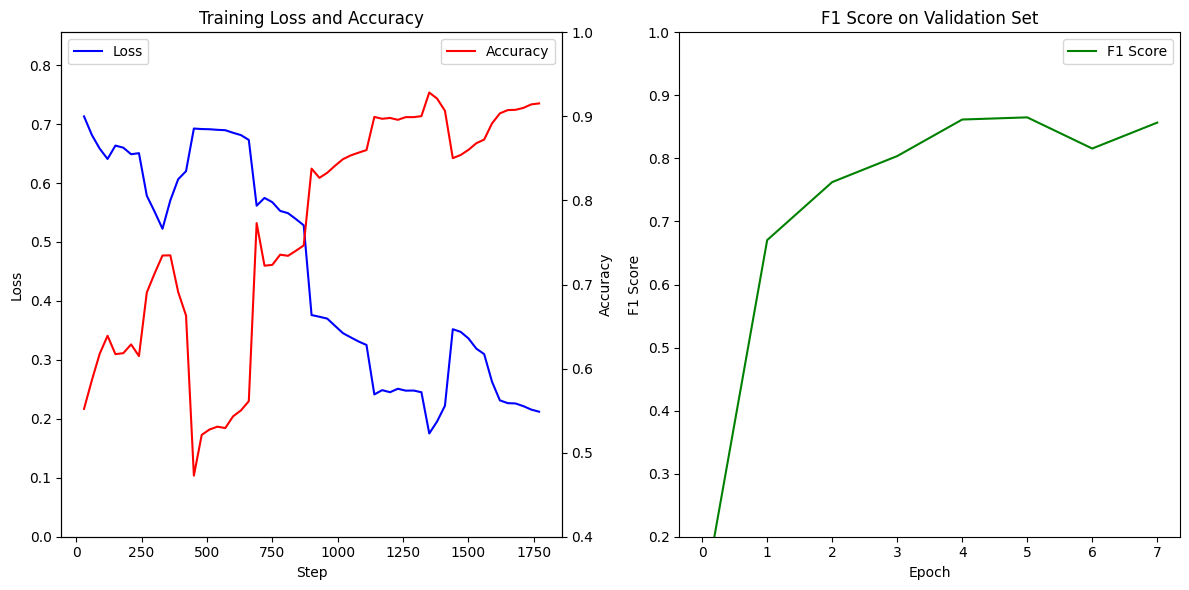

In [26]:
f1_callback = F1Callback(test_dataset, patience=2, model_save_path='GRU_without_word2vec')

baseline_model.fit(train_dataset, epochs=20, callbacks=[f1_callback])

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**2.3.2** - Directly using pre-trained `word2vec`
    
For this section, use the pre-trained `word2vec` embeddings directly into your model.

You can use the same `tf.data.Dataset` from 2.3.1 for this model
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.
</div>

In [31]:
# Your code here
embedding_matrix = pickle.load(open("embedding_matrix.pkl", "rb"))['embedding_matrix']

In [24]:
from keras.regularizers import l2 
# Parameters
vocab_size = 5000  # define your vocab size according to your data
embedding_dim = 300  # define the embedding dimensions

# Model
word2vec_gru_model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            embedding_dim,
                            weights=[embedding_matrix],  # use the embedding matrix as the weights
                            input_length=200,   # input_length: The length of input sequences
                            )

word2vec_gru_model.add(embedding_layer)
word2vec_gru_model.add(GRU(300, return_sequences=True))
word2vec_gru_model.add(GRU(300))
word2vec_gru_model.add(Dense(1, activation='sigmoid'))

word2vec_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

word2vec_gru_model.summary()    


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          1500000   
                                                                 
 gru_2 (GRU)                 (None, 200, 300)          541800    
                                                                 
 gru_3 (GRU)                 (None, 300)               541800    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 2,583,901
Trainable params: 2,583,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


2023-08-03 19:15:11.500894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:15:11.780777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:15:12.265291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:15:12.817354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:15:13.483760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


223/223 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5009

2023-08-03 19:15:45.400498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:15:45.484035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:15:45.953581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 - Validation F1: 0.0011


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


Best F1 score: 0.0011, saving model to GRU_with_word2vec
223/223 [==============================] - 54s 224ms/step - loss: 0.6940 - accuracy: 0.5009
Epoch 2/20
223/223 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.4958 - Validation F1: 0.6717


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


Best F1 score: 0.6717, saving model to GRU_with_word2vec
223/223 [==============================] - 47s 209ms/step - loss: 0.7012 - accuracy: 0.4958
Epoch 3/20
223/223 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.5896 - Validation F1: 0.8111


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


Best F1 score: 0.8111, saving model to GRU_with_word2vec
223/223 [==============================] - 49s 219ms/step - loss: 0.6336 - accuracy: 0.5896
Epoch 4/20
223/223 [==============================] - 43s 194ms/step - loss: 0.3286 - accuracy: 0.8630
Epoch 5/20
223/223 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7256 - Validation F1: 0.8512


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


Best F1 score: 0.8512, saving model to GRU_with_word2vec
223/223 [==============================] - 49s 222ms/step - loss: 0.5214 - accuracy: 0.7256
Epoch 6/20
223/223 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8827 - Validation F1: 0.8692


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


Best F1 score: 0.8692, saving model to GRU_with_word2vec
223/223 [==============================] - 49s 222ms/step - loss: 0.2873 - accuracy: 0.8827
Epoch 7/20
223/223 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9066 - Validation F1: 0.8744


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


INFO:tensorflow:Assets written to: GRU_with_word2vec/assets


Best F1 score: 0.8744, saving model to GRU_with_word2vec
223/223 [==============================] - 48s 217ms/step - loss: 0.2333 - accuracy: 0.9066
Epoch 8/20
223/223 [==============================] - 43s 194ms/step - loss: 0.2101 - accuracy: 0.9181
Epoch 9/20
223/223 [==============================] - 43s 195ms/step - loss: 0.1993 - accuracy: 0.9237
Epoch 10/20
223/223 [==============================] - 44s 195ms/step - loss: 0.1794 - accuracy: 0.9332
Epoch 11/20
223/223 [==============================] - 43s 195ms/step - loss: 0.1572 - accuracy: 0.9431
Epoch 12/20
223/223 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9405 - Validation F1: 0.8659
Early stopping at epoch 11, the best F1 score is 0.8744
223/223 [==============================] - 43s 191ms/step - loss: 0.1589 - accuracy: 0.9405


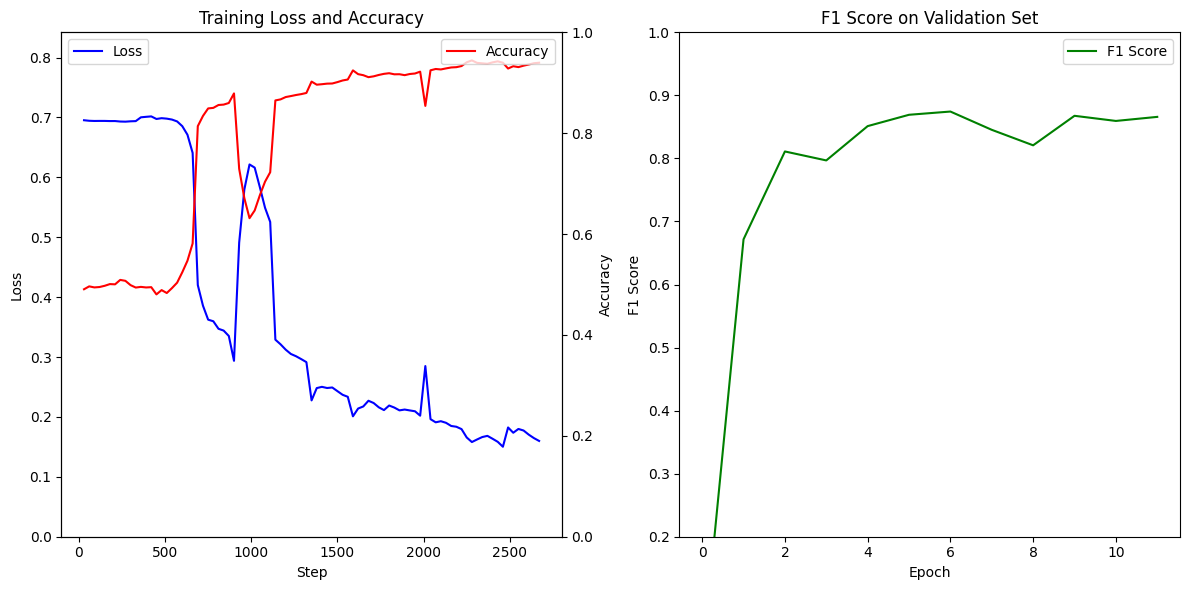

In [25]:
f1_callback = F1Callback(test_dataset, patience=5, model_save_path='GRU_with_word2vec')

word2vec_gru_model.fit(train_dataset, epochs=20, callbacks=[f1_callback])

#### Comparison

We use F1 score on the validation set. Using word2vec to initialize the embedding layer can better enhance the robustness of the model, enabling it to converge faster, and the optimal F1 score achieved is also higher than that with random initialization.

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.3.3** You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.

Using ELMo embeddings:

You will build another `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). This model also requires two inputs one for forward and one for backward LSTM.

For this model, you will use:
- `Toy_ELMo` model after the input layer
-  Sauce layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer

**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model.
        
Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

$$ELMo_{t} = \gamma \sum_{j=0}^{L} s_{j} h_{t}^{j}$$

Since we are not using any other embeddings, we will set the value of $\gamma$ to 1. <br>
Train the modified model sufficiently, and compare it to the previously trained models.

</div>  

In [30]:
# Helper code
# Scale layer for sauce
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ScaleLayer, self).__init__()
        self.supports_masking = True
        self.shape = shape

    def build(self, inputs):
        sauce_initializer = tf.keras.initializers.Constant(value = [0.4, 0.3, 0.3])
        self.scale = self.add_weight(shape = (self.shape,), initializer = sauce_initializer, trainable = True)

    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)
        return tf.tensordot(inputs, scale_norm, axes=[[-1], [-1]])

In [31]:
class ElmoAndGRU(Model):
    def __init__(self, vocab_size, embed_dim, num_units):
        super().__init__()
        self.elmo_model = Toy_Elmo(vocab_size=vocab_size, embed_dim=embed_dim, num_units=num_units, return_elmo=True)
        self.linear1 = Dense(num_units, activation='relu')
        self.linear2 = Dense(num_units, activation='relu')
        self.scale_layer = ScaleLayer(3)  # Add one scale layer for all embeddings
        self.sequential = Sequential([
            GRU(num_units, return_sequences=True),
            GRU(num_units),
            Dense(1, activation='softmax')
        ])
    
    def call(self, inputs):
        embedding1, embedding2, embedding3 = self.elmo_model(inputs) 
        embedding2 = self.linear1(embedding2)
        embedding3 = self.linear2(embedding3)
        # Stack embeddings along a new axis
        embeddings = tf.stack([embedding1, embedding2, embedding3], axis=-1)
        # Use the scale layer, then sum along the new axis
        scaled_embeddings = self.scale_layer(embeddings)
        x = self.sequential(scaled_embeddings)
        return x


In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

N_train = [len(n) for n in train_data]
N_test = [len(n) for n in test_data]
train_data = pad_sequences(train_data, maxlen=200, padding='post')
test_data = pad_sequences(test_data, maxlen=200, padding='post')

train_dataset = tf.data.Dataset.from_tensor_slices(((train_data, N_train), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_data, N_test), test_labels))

# Batching datasets
BATCH_SIZE = 64
SEED = 42
train_dataset = train_dataset.shuffle(8 * BATCH_SIZE, seed=SEED).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
elmo_gru_model = ElmoAndGRU(vocab_size=5000, embed_dim=300, num_units=300)

# load the checkpoint
elmo_gru_model.elmo_model.load_weights(tf.train.latest_checkpoint("Elmo_Checkpoint/"))
print("Loaded weights from Elmo_Checkpoint/")

elmo_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   

history = elmo_gru_model.fit(train_dataset, epochs=20)

However, when we replaced the entire embedding layer with a pre-trained ELMo, I found that the model had difficulty converging to excellent performance. The final F1 score of the test set only reached 0.7. Perhaps adopting a smaller learning rate or using weight decay l2 regularization could help, but due to time constraints, we didn't make further attempts.